***
# <font color=lightblue size=6>`1. Introduccion</font>
***

🎯 **Misión**

Desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.


---



🧠 **Objetivos del Desafío**

Preparar los datos para el modelado (tratamiento, codificación, normalización).

* Realizar análisis de correlación y selección de variables.

* Entrenar dos o más modelos de clasificación.

* Evaluar el rendimiento de los modelos con métricas.

* Interpretar los resultados, incluyendo la importancia de las variables.

* Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.


***
# <font color=lightblue size=6>2. Importacion de librerias y librerias</font>
***

## <font color='#EB984E'>**Importacion de librerias**</font>

In [ ]:
# Importacion de df
import pandas as pd

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder # Transformacion de variable objetivo

# Normalizacion de datos
from sklearn.preprocessing import MinMaxScaler

# Modelo KNN
from sklearn.neighbors import KNeighborsClassifier

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Se paracion de datos
from sklearn.model_selection import train_test_split

# Balanceo de datos
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
# Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

# Modelos de clasificacion
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier # Arbol de Desicion
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.neighbors import KNeighborsClassifier # KNN

# Matriz de confusion y metricas
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay , classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Validacion cruzada
from sklearn.model_selection import StratifiedKFold , cross_val_score

# Curva ROC
from sklearn.metrics import RocCurveDisplay , roc_auc_score
# Curva de precision vs recall
from sklearn.metrics import PrecisionRecallDisplay , average_precision_score

# Ajuste de hiperparametros
from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

## <font color='#EB984E'>**Funciones**</font>

In [ ]:
def calcular_vif(dataframe, columna_objetivo=None):
    """
    Calcula el VIF (Factor de Inflación de la Varianza) para un DataFrame.

    Parámetros:
    - dataframe: pd.DataFrame con todas las variables.
    - columna_objetivo: str o None. Si se especifica, esa columna será excluida.

    Retorna:
    - DataFrame con columnas 'Variable' y 'VIF'
    """
    df_vif = dataframe.copy()

    # Eliminar columna objetivo si se proporciona
    if columna_objetivo is not None and columna_objetivo in df_vif.columns:
        df_vif = df_vif.drop(columns=columna_objetivo)

    # Agregar constante
    df_vif = sm.add_constant(df_vif)

    # Calcular VIF
    vif_resultado = pd.DataFrame()
    vif_resultado['Variable'] = df_vif.columns
    vif_resultado['VIF'] = [
        variance_inflation_factor(df_vif.values, i)
        for i in range(df_vif.shape[1])
    ]

    # Opcional: excluir la constante si no quieres verla
    vif_resultado = vif_resultado[vif_resultado['Variable'] != 'const']

    return vif_resultado.reset_index(drop=True)

In [ ]:
def codificar_dataframe(X_, columnas_categoricas, drop='if_binary'):
    """
    Codifica variables categóricas de un DataFrame usando OneHotEncoder.

    Parámetros:
    - X: pd.DataFrame con las variables explicativas.
    - columnas_categoricas: lista de nombres de columnas categóricas.
    - drop: str, opción para OneHotEncoder ('if_binary' o 'first').

    Retorna:
    - df_codificado: DataFrame codificado con nombres legibles.
    - X_encoded: numpy array codificado.
    """

    # Crear transformador
    codificador = make_column_transformer(
        (OneHotEncoder(drop=drop), columnas_categoricas),
        remainder='passthrough',
        sparse_threshold=0
    )

    # Aplicar transformación
    X_encoded = codificador.fit_transform(X_)

    # Obtener nombres de columnas transformadas
    columnas_codificadas = [
        nombre.split('__')[1] for nombre in codificador.get_feature_names_out()
    ]

    # Crear DataFrame codificado
    df_codificado = pd.DataFrame(X_encoded, columns=columnas_codificadas, index=X.index)

    return df_codificado, X_encoded


In [ ]:
def intervalo_confianza(resultados , modelo = 'Modelo'):

  """
    Calcula un intervalo de confianza (aproximado) para una métrica con base en validación cruzada.

    Parámetros:
    - resultados: array o lista de resultados de validación cruzada (por ejemplo, scores de recall).

    Retorna:
    - Tupla con el intervalo de confianza: (limite_inferior, limite_superior)
  """

  promedio = resultados.mean()
  desv_std = resultados.std()

  return [max(promedio - 2 * desv_std , 0) , min(promedio + 2 * desv_std , 1)]




In [ ]:
def evaluar_modelo_clasificacion(modelo, y_val, y_pred, nombre_modelo='Modelo'):
    """
    Entrena y evalúa un modelo de clasificación, mostrando matriz de confusión y reporte de clasificación.

    Parámetros:
    - modelo: instancia del clasificador (ya entrenado).
    - y_val: datos de validación.
    - y_pred: datos de prediccion
    - nombre_modelo: etiqueta que identifica el modelo para los títulos y reportes.
    """

    # Metricas
    matriz = confusion_matrix(y_val, y_pred)

    print(f"\n--- Resultados para {nombre_modelo} ---")

    disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Matriz de Confusión - {nombre_modelo}')

    print(classification_report(y_val, y_pred))


In [ ]:
def obtener_metricas_modelo(nombre_modelo, y_true, y_pred, cv_scores=None, metodo=None):
    """
    Calcula métricas de evaluación para un modelo de clasificación binaria.

    Parámetros:
    - nombre_modelo: str, nombre identificador del modelo.
    - y_true: array o serie de valores verdaderos de la variable objetivo.
    - y_pred: array o serie de valores predichos por el modelo.
    - cv_scores: array o lista de resultados obtenidos por validación cruzada (por ejemplo, recall o f1).

    Retorna:
    - Un diccionario con las métricas:
        - 'Modelo': nombre del modelo
        - 'Accuracy': exactitud
        - 'Precision': precisión
        - 'Recall': sensibilidad
        - 'F1-Score': media armónica entre precisión y recall
        - 'Intervalo de Confianza': string con los límites inferior y superior del intervalo
    """
    if cv_scores is not None:
      intervalo = intervalo_confianza(cv_scores)
    else:
      intervalo = [40,100]

    metricas_dict = {
        'Modelo': nombre_modelo,
        'Accuracy': np.round(accuracy_score(y_true, y_pred), 4),
        'Precision': np.round(precision_score(y_true, y_pred), 4),
        'Recall': np.round(recall_score(y_true, y_pred), 4),
        'F1-Score': np.round(f1_score(y_true, y_pred), 4),
        'Intervalo de Confianza': [f" {np.round(intervalo[0], 4)} - {np.round(intervalo[1], 4)} "],
        'Metodo': metodo
    }

    if cv_scores is None:
      metricas_dict.pop('Modelo', None)
      metricas_dict.pop('Intervalo de Confianza', None)
      metricas_dict.pop('Metodo', None)

    return metricas_dict

In [ ]:
def mostrar_modelos(df, tipo_modelo):
    """
    Filtra y muestra métricas para un tipo de modelo específico usando un heatmap.

    Parámetros:
    df (pd.DataFrame): Debe contener ['Modelo','Accuracy','Precision','Recall','F1-Score','Intervalo de Confianza','Metodo']
    tipo_modelo (str): Texto para filtrar (ej: 'Random Forest', 'Decision Tree', 'KNN')
    """
    # Filtrar
    df_filtrado = df[df['Modelo'].str.contains(tipo_modelo, case=False, na=False)].copy()

    if df_filtrado.empty:
        print(f"No se encontraron modelos que contengan: {tipo_modelo}")
        return

    # Ordenar por Recall
    df_filtrado = df_filtrado.sort_values(by='Recall', ascending=False)

    # Plot con seaborn
    plt.figure(figsize=(10, len(df_filtrado) * 0.6))
    ax = sns.heatmap(df_filtrado[['Accuracy', 'Precision', 'Recall', 'F1-Score']],
                     annot=True, fmt=".4f", cmap="coolwarm", cbar=True,
                     linewidths=0.5, linecolor='gray')
    ax.set_title(f"Métricas - {tipo_modelo}", fontsize=14)
    plt.yticks(ticks=[i + 0.5 for i in range(len(df_filtrado))],
               labels=df_filtrado['Modelo'], rotation=0)
    plt.show()

    # Mostrar tabla con info extra
    display(df_filtrado[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
                         'Intervalo de Confianza', 'Metodo']])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import math

def evaluar_varios_modelos(modelos_info, y_val):
    """
    Muestra subplots con matrices de confusión para varios modelos.

    Parámetros:
    - modelos_info: lista de tuplas (nombre_modelo, y_pred)
    - y_val: datos reales de validación
    """
    total_modelos = len(modelos_info)
    cols = 3  # número de columnas en la figura
    rows = math.ceil(total_modelos / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # para iterar fácilmente

    for i, (nombre, y_pred) in enumerate(modelos_info):
        matriz = confusion_matrix(y_val, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(nombre)
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Real")

        # Mostrar métricas en consola
        print(f"\n--- Resultados para {nombre} ---")
        print(classification_report(y_val, y_pred))

    # Ocultar subplots vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_feature_importances(modelo, X_):
    """
    Recibe un modelo entrenado con atributo feature_importances_ y un DataFrame X con las features.
    Imprime un DataFrame con las importancias y grafica las importancias en orden descendente.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Extraer importancias
    importances = modelo.feature_importances_

    # Crear DataFrame con importancias en porcentaje y ordenado
    feature_importances = pd.DataFrame({
        'Features': X_.columns,
        'Importances': (importances * 100).round(2)
    }).sort_values('Importances', ascending=False)

    #print(feature_importances)

    # Escala de azules según importancia
    colors = plt.cm.Blues(feature_importances['Importances'] / feature_importances['Importances'].max())

    # Graficar
    plt.figure(figsize=(10, 0.6*len(feature_importances)))  # Ajusta altura según cantidad de features
    bars = plt.barh(feature_importances['Features'], feature_importances['Importances'],
                    color=colors, edgecolor='black', height=0.6)  # Barras más gruesas

    # Mostrar valor de importancia en cada barra
    for bar, imp in zip(bars, feature_importances['Importances']):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{imp}%', va='center', ha='left', fontsize=10)

    # Configuración del gráfico
    plt.gca().invert_yaxis()  # Para que la característica más importante quede arriba
    plt.xticks([])  # Eliminar eje X
    plt.ylabel('')
    plt.title('Importancia de las características', fontsize=14)

    # Quitar los spines de la derecha y abajo
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()


In [ ]:
def plot_feature_importances_knn(feature_importances):
    """
    Recibe un DataFrame con columnas 'Features' y 'Importances' y grafica la importancia de cada característica.
    """
    import matplotlib.pyplot as plt

    # Ordenar de mayor a menor importancia
    feature_importances = feature_importances.sort_values('Importances', ascending=False)

    # Escala de azules según importancia
    colors = plt.cm.Blues(feature_importances['Importances'] / feature_importances['Importances'].max())

    # Graficar
    plt.figure(figsize=(10, 0.6*len(feature_importances)))  # Altura según cantidad de features
    bars = plt.barh(feature_importances['Features'], feature_importances['Importances'],
                    color=colors, edgecolor='black', height=0.6)

    # Mostrar valor de importancia en cada barra
    for bar, imp in zip(bars, feature_importances['Importances']):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{imp}%', va='center', ha='left', fontsize=10)

    # Configuración del gráfico
    plt.gca().invert_yaxis()  # Feature más importante arriba
    plt.xticks([])  # Eliminar eje X
    plt.ylabel('')
    plt.title('Importancia de las características', fontsize=14)

    # Quitar spines derecho e inferior
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()


***
# <font color=lightblue size=6>3. Preparacion de Datos</font>
***

In [ ]:
# Carga de datos
url = 'https://raw.githubusercontent.com/EJoelCM/analisis_predictivo_telecomX/refs/heads/main/df_telecom_clean.csv'

df_telecom = pd.read_csv(url)
df_telecom.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal,Cuentas_diarias
0,0,Female,0,1,1,9,1,0,DSL,0,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0,Male,0,0,0,9,1,1,DSL,0,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,1,Male,0,0,0,4,1,0,Fiber optic,0,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333
3,1,Male,1,1,0,13,1,0,Fiber optic,0,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.266667
4,1,Female,1,1,0,3,1,0,Fiber optic,0,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.796667


In [ ]:
# Eliminacion de columnas irrelevantes

df_telecom.drop(columns=['ChargesMonthly' , 'Cuentas_diarias'] , axis=1 , inplace=True)


<font color='#5DADE2'><b>Nota:</b></font>  
Debido a que las columnas `ChargesMonthly` , `Cuentas_diarias` y `Cuentas_diarias` presentan información similar o redundante, se procederá a eliminarlas para evitar multicolinealidad y simplificar el modelo.


## <font color='#EB984E'>**Encoding de variables categóricas**</font>

In [ ]:
# Separacion de df en variable objetivo y explicativas

X = df_telecom.drop(columns='Churn', axis = 1)
y = df_telecom['Churn']

X_copy = X.copy()
y_copy = y.copy()

columnas_categoricas = []
columnas  = X.columns

for i in df_telecom.columns:
  if df_telecom[i].dtype == object:
    columnas_categoricas.append(i)



In [ ]:
df , X_encoded = codificar_dataframe(X, columnas_categoricas , drop='if_binary')
df_linear , X_linear = codificar_dataframe(X, columnas_categoricas , drop='first')
df

,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,ChargesTotal
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,593.30
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,542.40
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,280.85
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1237.85
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,742.90
7028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1873.70
7029,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,92.75
7030,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4627.65


In [ ]:
# Transformacion de variable objetivo

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
# Proporcion de cancelacion

churn_proporcion = y_copy.value_counts().reset_index()
churn_proporcion['Porcentaje %'] = round(y_copy.value_counts(normalize=True) * 100, 2)
churn_proporcion

,Churn,count,Porcentaje %
0,0,5163,73.42
1,1,1869,26.58


## <font color='#EB984E'>**Normalizacion de datos**</font>

In [ ]:
# Normalizacion

normalizado = MinMaxScaler()
X_normalizado = normalizado.fit_transform(X_encoded)
pd.DataFrame(X_normalizado)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.066294
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.060420
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.030239
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.140670
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.028687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.083556
7028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.214043
7029,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.008533
7030,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.531831


***
# <font color=lightblue size=6>4. Correlacion y Seleccion de variables</font>
***

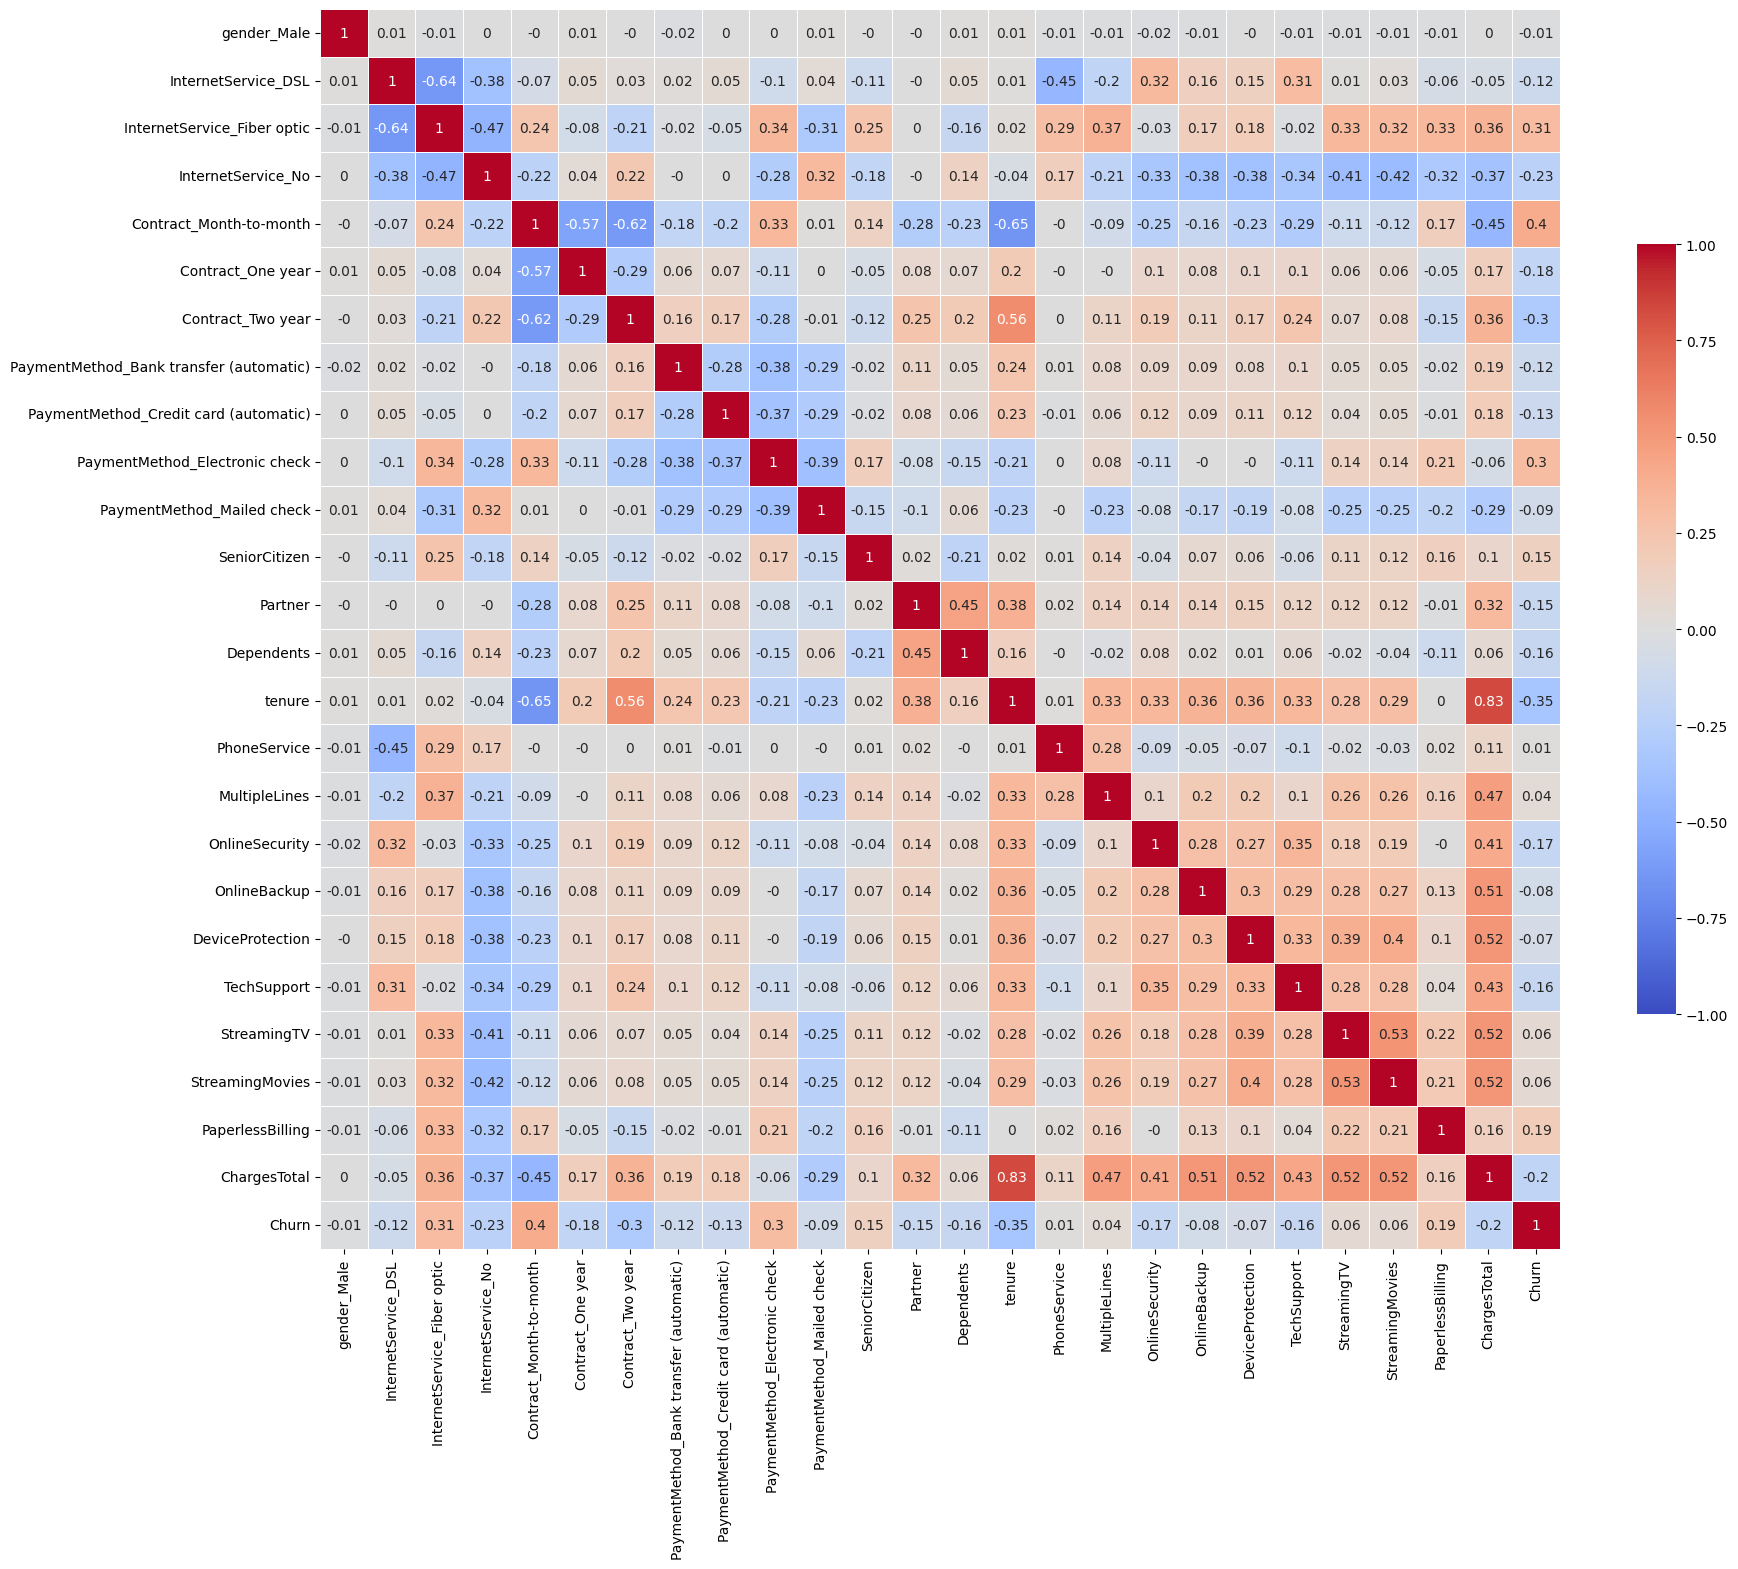

In [ ]:
df['Churn'] = y
correlacion = df.corr()
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(np.round(correlacion, 2), vmax=1, vmin=-1, center=0, square=True, linewidths=.7, annot=True, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

In [ ]:
np.round(correlacion['Churn'].sort_values(ascending=False) , 2)

,Churn
Churn,1.00
Contract_Month-to-month,0.40
InternetService_Fiber optic,0.31
PaymentMethod_Electronic check,0.30
PaperlessBilling,0.19
SeniorCitizen,0.15
StreamingTV,0.06
StreamingMovies,0.06
MultipleLines,0.04
PhoneService,0.01


### <font color='#f07c3e'>**Observaciones de coorrelacion**</font>


Se observa una fuerte relacion positiva entre `ChargesTotal` y `tenure`, es posible que la variable ya sea explicada entre ellas mismas, se verificara llevando a cabo un analisis de colinealidad con **Variance Inflation Factor** ***(VIF)***


## <font color='#EB984E'>**Analisis de multicolinealidad**</font>

| Rango de VIF        | Nivel de multicolinealidad | Interpretación/resumen                                 |
|---------------------|-----------------------------|--------------------------------------------------------|
| VIF < 5             | Baja                        | Aceptable                          |
| 5 ≤ VIF ≤ 10        | Moderada                    | Puede requerir atención.                 |
| VIF > 10            | Alta                        | Preocupante|

Para evitar la colinealidad perfecta en las columnas que fueron codificadas con `One-Hot Encoding` se utilizara la variable `X_linear` la cual fue creada con el parametro `drop='first'`

### <font color='#58D68D'>**VIF 1**</font>

In [ ]:
# Creacion de constante
df_vif = df_linear.copy()
df_vif = sm.add_constant(df_vif)

# Variables explicativas
explicativas = df_vif.columns


In [ ]:
# Creacion de VIF
vif_data = pd.DataFrame()
vif_data['Variables'] = explicativas
vif_data['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(explicativas))]
vif_data.sort_values('VIF' , ascending = False)

,Variables,VIF
0,const,27.355204
22,ChargesTotal,10.781958
12,tenure,7.572242
3,InternetService_No,2.752138
5,Contract_Two year,2.652316
2,InternetService_Fiber optic,2.398316
7,PaymentMethod_Electronic check,1.975991
8,PaymentMethod_Mailed check,1.856890
20,StreamingMovies,1.738445
19,StreamingTV,1.723829


#### <font color='#f07c3e'>**Observaciones de VIF 1**</font>

Se identifica un valor crítico en la variable `ChargesTotal` y un valor moderado en `tenure`, lo cual sugiere una posible relación acumulativa entre ambas. Dado que `ChargesTotal` podría estar reflejando el efecto del tiempo de permanencia (`tenure`), se propone excluir esta variable en el análisis posterior para evitar colinealidad y redundancia en la información.

### <font color='#58D68D'>**VIF 2**</font>

In [ ]:
# Creacion de constante y eliminacion de Churn para el analisis
df_vif = df_linear.copy()
df_vif.drop(columns='ChargesTotal' , inplace=True)
df_vif = sm.add_constant(df_vif)

# Variables explicativas
explicativas = df_vif.columns

# Resultados
vif_2 = pd.DataFrame()
vif_2['Variables'] = explicativas
vif_2['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(len(explicativas))]
vif_2.sort_values('VIF' , ascending = False)

,Variables,VIF
0,const,22.702516
12,tenure,2.827609
3,InternetService_No,2.692944
5,Contract_Two year,2.633220
2,InternetService_Fiber optic,2.005259
7,PaymentMethod_Electronic check,1.973648
8,PaymentMethod_Mailed check,1.837890
20,StreamingMovies,1.634755
19,StreamingTV,1.625973
4,Contract_One year,1.625660


#### <font color='#f07c3e'>**Observaciones de VIF 2**</font>

Tras la eliminación de la variable `ChargesTotal`, se observó una disminución significativa en la multicolinealidad del modelo. En particular, el VIF de la variable `tenure` se redujo a 2.827609, lo cual indica una mejora en la independencia lineal entre las variables predictoras. Este resultado respalda la decisión de excluir `ChargesTotal`, al tratarse de una variable derivada o acumulativa de `tenure`, cuya presencia generaba redundancia informativa en el modelo.

## <font color='#EB984E'>**Analisis dirigido**</font>

In [ ]:
df_telecom_graficas = df_telecom.copy()

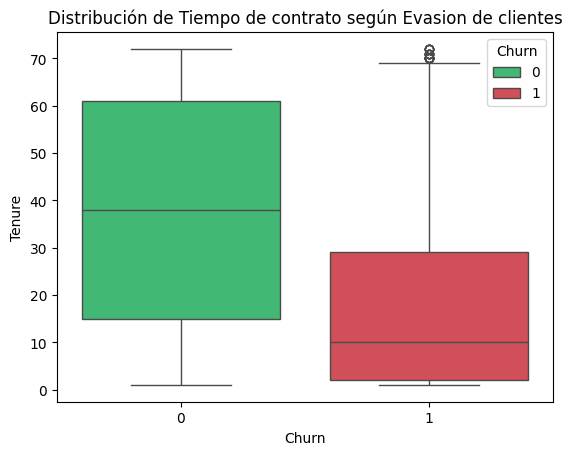

In [ ]:
tenure_boxplot = sns.boxplot(data=df_telecom_graficas, y='tenure', x='Churn',
                             hue='Churn', palette={1: '#E63946', 0: '#2ECC71'})
plt.title('Distribución de Tiempo de contrato según Evasion de clientes')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

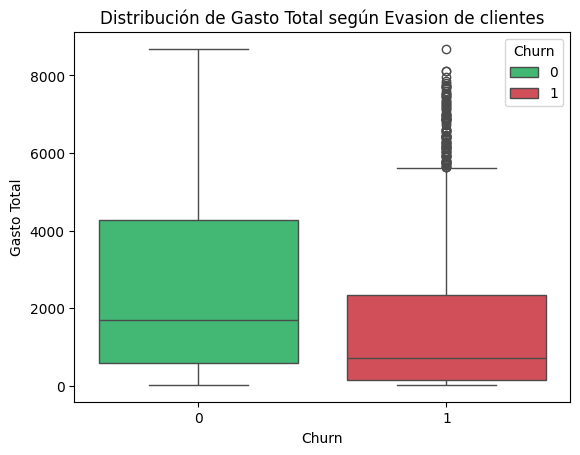

In [ ]:
chargestotal_boxplot= sns.boxplot(data=df_telecom_graficas, y='ChargesTotal', x='Churn',
                                  hue='Churn',  palette={1: '#E63946', 0: '#2ECC71'})
plt.title('Distribución de Gasto Total según Evasion de clientes')
plt.xlabel('Churn')
plt.ylabel('Gasto Total')
plt.show()

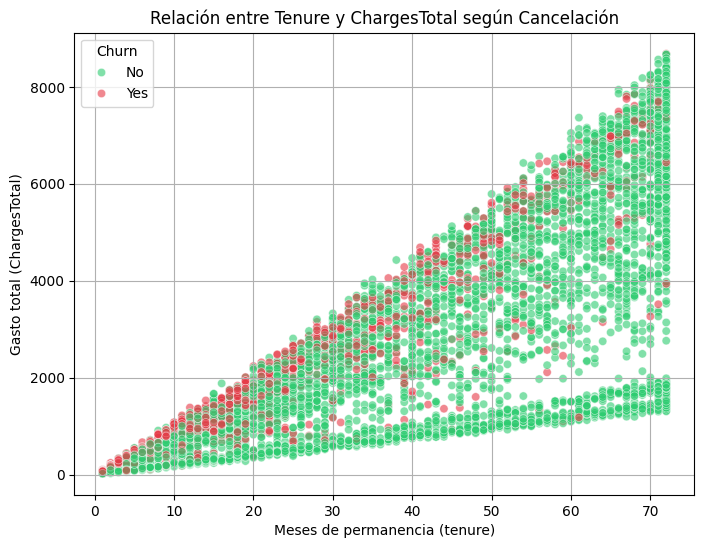

In [ ]:
df_telecom_graficas['Churn_str'] = df_telecom_graficas['Churn'].map({0: 'No', 1: 'Yes'})

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot( data=df_telecom_graficas, x='tenure', y='ChargesTotal',
                hue='Churn_str', palette={'Yes': '#E63946', 'No': '#2ECC71'}, alpha=0.6)

plt.title('Relación entre Tenure y ChargesTotal según Cancelación')
plt.xlabel('Meses de permanencia (tenure)')
plt.ylabel('Gasto total (ChargesTotal)')
plt.legend(title='Churn')
plt.grid(True)
plt.show()

### <font color='#f07c3e'>**Observaciones de Evasion de clientes en Tiempo de contrato y Cargos Totales'**</font>

Los clientes que cancelan el servicio `Churn` tienen un tiempo de permanencia `tenure` menor en comparacion a los que no cancelan. Por la caracteristica acumulativa de `CarguesTotal` se ve un comportamiento similar.

En la grafica de dispersión se detecta una concentracion mayor de clientes cancelados en una etapa temprana.

***
# <font color=lightblue size=6>5. Modelado Predictivo</font>
***

## <font color='#EB984E'>**Separacion de Datos**</font>

In [ ]:
X = df.drop(columns=['Churn'] , axis=1)
y = df['Churn']

X_temp, X_test, y_temp, y_test= train_test_split(X, y, stratify = y, test_size=0.05 ,random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=10)


## <font color='#EB984E'>**Balanceo de Datos**</font>

Dado el desbalance en la variable objetivo, con una distribución del `73.42 %` para la `clase 0` y `26.58 %` para la `clase 1`, se optó por aplicar únicamente técnicas de undersampling. En particular, se utilizó el algoritmo `NearMiss`, el cual permite reducir la cantidad de muestras de la clase mayoritaria seleccionando aquellas más cercanas a la clase minoritaria. Esta estrategia busca mitigar el sesgo del modelo hacia la clase mayoritaria y mejorar su capacidad de predicción sobre la clase minoritaria.

In [ ]:
smote = SMOTE(random_state=30)
X_train_smote , y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
nearmiss = NearMiss(version=3)
X_train_nearmiss , y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

In [ ]:
X_train.shape , y_train.shape

((5010, 25), (5010,))

In [ ]:
X_train_smote.shape , y_train_smote.shape

((7358, 25), (7358,))

In [ ]:
X_train_nearmiss.shape , y_train_nearmiss.shape

((2662, 25), (2662,))

## <font color='#EB984E'>**Creacion de Modelos**</font>

### <font color='#58D68D'>**Modelo Baseline: Decision Tree Classifier**</font>


--- Resultados para Modelo Baseline: Arbol de Decisiones ---
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1226
           1       0.54      0.52      0.53       444

    accuracy                           0.75      1670
   macro avg       0.68      0.68      0.68      1670
weighted avg       0.75      0.75      0.75      1670



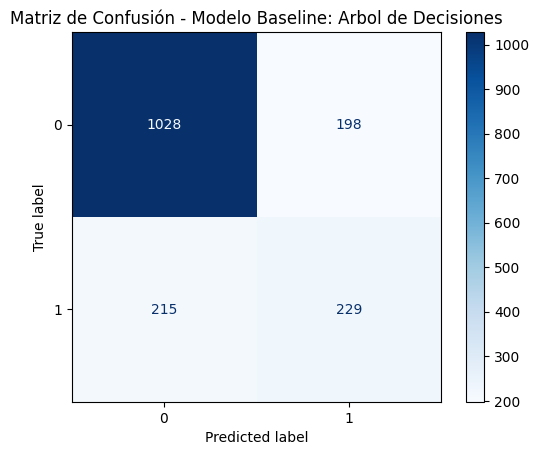

In [ ]:
# Creacion de modelo
modelo_Baseline_treeClass = DecisionTreeClassifier(random_state=10)
# Entrenamiento de modelo
modelo_Baseline_treeClass.fit(X_train, y_train)
# Prediccion del modelo
y_prevista_baseline = modelo_Baseline_treeClass.predict(X_val)

evaluar_modelo_clasificacion(modelo_Baseline_treeClass, y_val, y_prevista_baseline,
                              nombre_modelo='Modelo Baseline: Arbol de Decisiones')



In [ ]:
skf = StratifiedKFold( n_splits = 10 , shuffle = True , random_state = 10)
cv_resultados_treeClass = cross_val_score(modelo_Baseline_treeClass , X_temp , y_temp , cv = skf , scoring = 'recall')


In [ ]:
# Lista para el seguimiento de las metricas de los modelos
metricas_tracking = []

In [ ]:
metricas_tracking.append(obtener_metricas_modelo('Baseline DecisionTree', y_val, y_prevista_baseline, cv_resultados_treeClass))
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None


#### <font color='#f07c3e'>**Observaciones: Modelo Baseline**</font>

El objetivo de crear el modelo sin ajuste de hiperparametros o tecnicas de procesamiento es ser utilizado como **modelo de comparacion** para los siguientes modelo. Se debe considerar que las metricas indicadas para resultados de `Churn = 1` ya que se da prioridad a los casos de evasion


El area bajo la curva ROC es: 0.6771324750525403


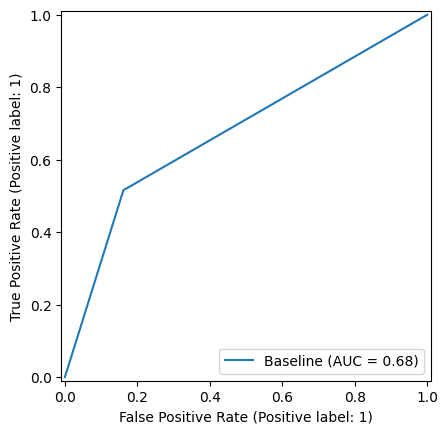

In [ ]:
RocCurveDisplay.from_predictions(y_val , y_prevista_baseline, name= 'Baseline');
print(f'El area bajo la curva ROC es: {roc_auc_score(y_val , y_prevista_baseline)}')

El score promedio del pecision vs recall es: 0.4053475743620045


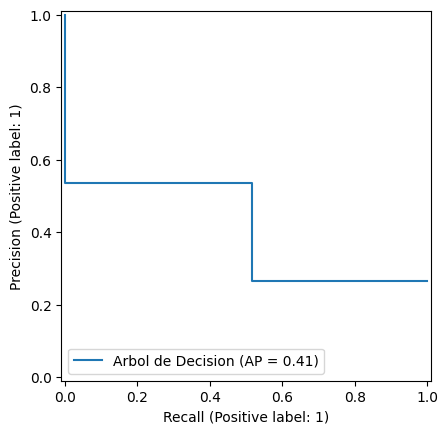

In [ ]:
PrecisionRecallDisplay.from_predictions(y_val , y_prevista_baseline, name= 'Arbol de Decision');
print(f'El score promedio del pecision vs recall es: {average_precision_score(y_val , y_prevista_baseline)}')



### <font color='#58D68D'>**Modelo 1: Decision Tree**</font>

Para este modelo se utulizara el proceso de oversampling y undersampling junto con ajuste de parametros

In [ ]:
modelo_descisionTree1 = DecisionTreeClassifier(max_depth=5 , random_state=33)
modelo_descisionTree1.fit(X_train_nearmiss, y_train_nearmiss)
y_val_pred_dt1 = modelo_descisionTree1.predict(X_val)



--- Resultados para Decision Tree ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1226
           1       0.56      0.70      0.62       444

    accuracy                           0.77      1670
   macro avg       0.72      0.75      0.73      1670
weighted avg       0.79      0.77      0.78      1670



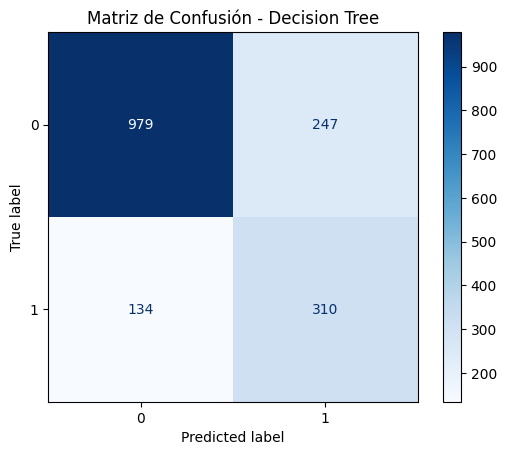

In [ ]:
evaluar_modelo_clasificacion(modelo_descisionTree1, y_val, y_val_pred_dt1,nombre_modelo='Decision Tree' )


In [ ]:
pipeline_descisionTree_nearmiss = imbpipeline([('undersalmple', NearMiss(version = 3)) ,
                                               ('arbol', modelo_descisionTree1)])
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)
cv_resultados_decisionTree_nearMiss = cross_val_score(pipeline_descisionTree_nearmiss, X_temp, y_temp,
                                                      cv = skf, scoring='recall')
intervalo_confianza(cv_resultados_decisionTree_nearMiss)


[np.float64(0.6274026700148486), np.float64(0.7935076327846183)]

In [ ]:
metricas_tracking.append(obtener_metricas_modelo('Decision Tree - 1' , y_val, y_val_pred_dt1, cv_resultados_decisionTree_nearMiss, 'NearMiss' ))
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss


### <font color='#58D68D'>**Modelo 2: Decision Tree**</font>

In [ ]:
importances = modelo_descisionTree1.feature_importances_
feature_importances = pd.DataFrame({'Features' : X.columns , 'Importances': (importances*100).round(2)}).sort_values('Importances' , ascending = False)
feature_importances

,Features,Importances
14,tenure,59.26
4,Contract_Month-to-month,16.64
2,InternetService_Fiber optic,7.36
24,ChargesTotal,3.41
22,StreamingMovies,3.07
9,PaymentMethod_Electronic check,2.75
15,PhoneService,2.28
5,Contract_One year,1.61
17,OnlineSecurity,1.17
11,SeniorCitizen,0.73


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = DecisionTreeClassifier(max_depth=5 , random_state=33)

ct_features = [ i if i != 0 else 1 for i in range(0,20,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_nearmiss[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15
Accuracy,0.7485,0.7575,0.7695,0.7719
Precision,0.5299,0.5316,0.5530,0.5566
Recall,0.4797,0.7387,0.6937,0.6982
F1-Score,0.5035,0.6183,0.6154,0.6194


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = DecisionTreeClassifier(max_depth=5 , random_state=33)

ct_features = range(1,10)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_nearmiss[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,2,3,4,5,6,7,8,9
Accuracy,0.7485,0.7341,0.7587,0.7575,0.7575,0.7725,0.7629,0.7701,0.7677
Precision,0.5299,0.5000,0.5327,0.5316,0.5316,0.5595,0.5420,0.5534,0.5495
Recall,0.4797,0.5788,0.7523,0.7387,0.7387,0.6779,0.6982,0.7005,0.7005
F1-Score,0.5035,0.5365,0.6237,0.6183,0.6183,0.6130,0.6102,0.6183,0.6158


In [ ]:
selected_features_dt2 = feature_importances['Features'].values[:3]
X_train_selected_features = X_train_nearmiss[selected_features_dt2]
X_train_selected_features

,tenure,Contract_Month-to-month,InternetService_Fiber optic
0,72.0,0.0,1.0
1,72.0,0.0,1.0
2,72.0,0.0,1.0
3,72.0,0.0,1.0
4,72.0,0.0,1.0
...,...,...,...
2657,27.0,1.0,1.0
2658,8.0,1.0,1.0
2659,11.0,1.0,0.0
2660,47.0,1.0,1.0


In [ ]:
modelo_descisionTree2 = DecisionTreeClassifier(max_depth=5 , random_state=33)
modelo_descisionTree2.fit(X_train_nearmiss[selected_features_dt2], y_train_nearmiss)
y_val_pred_dt2 = modelo_descisionTree2.predict(X_val[selected_features_dt2])


pipeline_descisionTree_nearmiss = imbpipeline([('undersalmple', NearMiss(version = 3)) ,
                                               ('arbol', modelo_descisionTree2)])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
cv_resultados_decisionTree_nearMiss = cross_val_score(pipeline_descisionTree_nearmiss, X_temp[selected_features_dt2], y_temp,
                                                      cv = skf, scoring='recall')

metricas_dt3 = obtener_metricas_modelo('Decision Tree - 2' , y_val, y_val_pred_dt2, cv_resultados_decisionTree_nearMiss,
                        'NearMiss, selected_features' )


/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The n

In [ ]:
metricas_tracking.append(metricas_dt3)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"


#### <font color='#f07c3e'>**Observaciones:**

Al combinar `NearMiss` con un subconjunto reducido de características (`selected_features`), el modelo puede encontrar un número insuficiente de muestras para aplicar correctamente el undersampling. Esto genera advertencias (`warnings`) que indican que el balanceo no se ha realizado, lo cual puede afectar la estabilidad de las métricas obtenidas por validación cruzada, haciendo que el intervalo de confianza no sea representativo o más amplio de lo esperado.

### <font color='#58D68D'>**Modelo 3: Decision Tree**</font>

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)
model_grid = GridSearchCV( DecisionTreeClassifier(random_state=33) , param_grid = param_grid , scoring='r2' , cv=skf )

model_grid.fit(X_train_selected_features, y_train_nearmiss)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=33, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=33),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.1],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             scoring='r2')

In [ ]:
model_grid.best_params_

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [ ]:
modelo_descisionTree3 = DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                                              min_samples_split=4, random_state=33)

modelo_descisionTree3.fit(X_train_nearmiss, y_train_nearmiss)
y_val_pred_dt3 = modelo_descisionTree3.predict(X_val)

pipeline_descisionTree_nearmiss = imbpipeline([('undersalmple', NearMiss(version = 3)) ,
                                               ('arbol', modelo_descisionTree3)])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
cv_resultados_decisionTree_nearMiss = cross_val_score(pipeline_descisionTree_nearmiss, X_temp, y_temp,
                                                      cv = skf, scoring='recall')

metricas_dt4 = obtener_metricas_modelo('Decision Tree - 3' , y_val, y_val_pred_dt3, cv_resultados_decisionTree_nearMiss,
                                        'NearMiss, GridSearchCV' )

In [ ]:
metricas_tracking.append(metricas_dt4)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"


#### <font color='#f07c3e'>**Observaciones:**

El modelo `Decision Tree - 3` presenta un `recall` promedio de `0.8198`, pero con un intervalo de confianza amplio: `[0.6802 - 0.8048]`. Esta variabilidad indica que el rendimiento del modelo no es consistente entre diferentes particiones de los datos. Por ello, a pesar del buen desempeño promedio, no se considera un modelo estable. Esto puede deberse al uso de técnicas de undersampling, que reducen la cantidad de datos disponibles y aumentan la sensibilidad del modelo.

### <font color='#58D68D'>**Modelo 4: Decision Tree**</font>

Para aplicar `GridSearchCV` junto con la selección de características (`selected_features`), se optó por utilizar la técnica de undersampling llamada `RandomUnderSampler`.

A diferencia de `NearMiss`, que puede generar advertencias cuando hay pocos datos o características, `RandomUnderSampler` realiza una selección aleatoria de la clase mayoritaria, asegurando un conjunto balanceado sin depender de distancias entre muestras.

Esto permite una integración más estable con `GridSearchCV`, ya que en cada partición se mantiene la diversidad de datos necesaria para evaluar combinaciones de hiperparámetros de forma fiable.

In [ ]:
modelo_descisionTree4 = DecisionTreeClassifier(max_depth=5, random_state=33)


pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('arbol', modelo_descisionTree4) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp, y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)


[np.float64(0.6755416543378057), np.float64(0.8478824553555862)]

In [ ]:
rus = RandomUnderSampler(random_state=33)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
modelo_descisionTree4.fit(X_train_rus, y_train_rus)
y_pred_rus_dt4 = modelo_descisionTree4.predict(X_val)

metricas_rus = obtener_metricas_modelo('Decision Tree - 4', y_val, y_pred_rus_dt4, cv_resultados_rus, 'RandomUnderSampler')
metricas_tracking.append(metricas_rus)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler


### <font color='#58D68D'>**Modelo 5: Decision Tree**</font>

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)
model_grid = GridSearchCV( DecisionTreeClassifier(random_state=33) , param_grid = param_grid , scoring='r2' , cv=skf )

model_grid.fit(X_train_rus, y_train_rus)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=33, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=33),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.1],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             scoring='r2')

In [ ]:
model_grid.best_params_

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [ ]:
modelo_descisionTree5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('arbol', modelo_descisionTree5) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp, y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)

[np.float64(0.675158248530874), np.float64(0.8460186701512817)]

In [ ]:
modelo_descisionTree5.fit(X_train_rus, y_train_rus)
y_pred_rus_dt5 = modelo_descisionTree4.predict(X_val)

metricas_rus = obtener_metricas_modelo('Decision Tree - 5', y_val, y_pred_rus_dt5, cv_resultados_rus, 'RandomUnderSampler, GridSearchCV')
metricas_tracking.append(metricas_rus)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"


### <font color='#58D68D'>**Modelo 6: Decision Tree**</font>

In [ ]:
importances = modelo_descisionTree5.feature_importances_
feature_importances = pd.DataFrame({'Features' : X.columns , 'Importances': (importances*100).round(2)}).sort_values('Importances' , ascending = False)
feature_importances

,Features,Importances
4,Contract_Month-to-month,58.02
2,InternetService_Fiber optic,13.37
14,tenure,10.68
24,ChargesTotal,3.74
5,Contract_One year,3.06
9,PaymentMethod_Electronic check,2.64
22,StreamingMovies,2.31
15,PhoneService,1.62
3,InternetService_No,1.41
20,TechSupport,1.20


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)

ct_features = [ i if i != 0 else 1 for i in range(0,20,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_rus[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15
Accuracy,0.6539,0.7515,0.7563,0.7365
Precision,0.4287,0.5210,0.5269,0.5027
Recall,0.9077,0.8108,0.8176,0.8243
F1-Score,0.5824,0.6344,0.6408,0.6246


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)

ct_features = range(1,10)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_rus[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,2,3,4,5,6,7,8,9
Accuracy,0.6539,0.6539,0.7491,0.7503,0.7515,0.7323,0.7353,0.7431,0.7551
Precision,0.4287,0.4287,0.5183,0.5194,0.5210,0.4980,0.5014,0.5105,0.5255
Recall,0.9077,0.9077,0.7973,0.8131,0.8108,0.8288,0.8266,0.8198,0.8131
F1-Score,0.5824,0.5824,0.6282,0.6339,0.6344,0.6221,0.6241,0.6292,0.6384


In [ ]:
selected_features_dt6 = feature_importances['Features'].values[:5]
X_train_selected_features_rus = X_train_rus[selected_features_dt6]
X_train_selected_features_rus

,Contract_Month-to-month,InternetService_Fiber optic,tenure,ChargesTotal,Contract_One year
560,0.0,1.0,45.0,4442.75,1.0
4853,0.0,0.0,72.0,1432.55,0.0
3887,0.0,0.0,31.0,697.70,0.0
1197,0.0,0.0,66.0,1269.10,0.0
2663,1.0,0.0,30.0,1474.90,0.0
...,...,...,...,...,...
5715,1.0,1.0,27.0,2287.25,0.0
5128,1.0,1.0,8.0,780.50,0.0
3444,1.0,0.0,11.0,214.75,0.0
440,1.0,1.0,47.0,3825.85,0.0


In [ ]:
modelo_descisionTree6 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('arbol', modelo_descisionTree6) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp[selected_features_dt6], y_temp,
                                    cv=skf, scoring='recall')

In [ ]:
modelo_descisionTree6 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)
modelo_descisionTree6.fit(X_train_selected_features_rus, y_train_rus)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=33)

In [ ]:
y_pred_rus_dt6 = modelo_descisionTree6.predict(X_val[selected_features_dt6])

metricas_rus = obtener_metricas_modelo('Decision Tree - 6', y_val, y_pred_rus_dt6, cv_resultados_rus, 'RandomUnderSampler, GridSearchCV, selected_features')
metricas_tracking.append(metricas_rus)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."


### <font color='#58D68D'>**Modelo 7: Random Forest**</font>

In [ ]:
modelo_rf1 = RandomForestClassifier(max_depth=2 , random_state=3)

pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                            ('rf1', modelo_rf1) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rf1 = cross_val_score(pipeline, X_temp, y_temp,
                                    cv=skf, scoring='recall')

modelo_rf1.fit(X_train_nearmiss, y_train_nearmiss)


RandomForestClassifier(max_depth=2, random_state=3)

In [ ]:
y_val_pred_rf1 = modelo_rf1.predict(X_val)
metricas_rf1 = obtener_metricas_modelo('Random Forest - 1', y_val, y_val_pred_rf1, cv_resultados_rf1, 'NearMiss')
metricas_tracking.append(metricas_rf1)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss


### <font color='#58D68D'>**Modelo 8: Random Forest**</font>

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 6, 8, None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

In [ ]:
modelo_rf2 = RandomForestClassifier(random_state=3)

grid_search_rf = GridSearchCV(estimator=modelo_rf2, param_grid=param_grid, cv=5,
                              scoring='recall',  n_jobs=-1, verbose=3)

grid_search_rf.fit(X_train_nearmiss, y_train_nearmiss)


Fitting 5 folds for each of 8640 candidates, totalling 43200 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10800 fits failed out of a total of 43200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8516 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall', verbose=3)

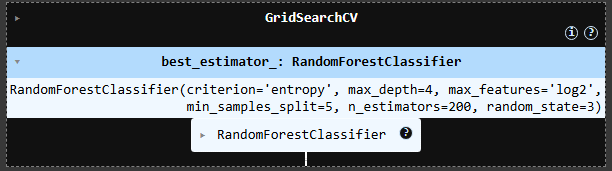

In [ ]:
print("Mejores hiperparámetros encontrados:", grid_search_rf.best_params_)


Mejores hiperparámetros encontrados: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
rf2_best_params = {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
rf2_best_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
modelo_rf2 = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       min_samples_split=5, n_estimators=200, random_state=3)

pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                            ('rf2', modelo_rf2) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rf2 = cross_val_score(pipeline, X_temp, y_temp,
                                    cv=skf, scoring='recall')

modelo_rf2.fit(X_train_nearmiss, y_train_nearmiss)
y_val_pred_rf2 = modelo_rf2.predict(X_val)


In [ ]:
metricas_rf2 = obtener_metricas_modelo('Random Forest - 2', y_val, y_val_pred_rf2, cv_resultados_rf2, 'NearMiss, GridSearchCV')
metricas_tracking.append(metricas_rf2)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"


### <font color='#58D68D'>**Modelo 9: Random Forest**</font>

In [ ]:
importances = modelo_rf2.feature_importances_
feature_importances = pd.DataFrame({'Features' : X.columns , 'Importances': (importances*100).round(2)}).sort_values('Importances' , ascending = False)
feature_importances

,Features,Importances
14,tenure,25.79
24,ChargesTotal,22.25
4,Contract_Month-to-month,15.01
6,Contract_Two year,5.96
20,TechSupport,5.15
9,PaymentMethod_Electronic check,4.51
17,OnlineSecurity,4.14
5,Contract_One year,3.38
2,InternetService_Fiber optic,3.29
1,InternetService_DSL,1.93


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                                        min_samples_split=5, n_estimators=200, random_state=3)

ct_features = [ i if i != 0 else 1 for i in range(0,35,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_nearmiss[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15,20,25,30
Accuracy,0.7491,0.7431,0.7737,0.7689,0.7731,0.7713,0.7713
Precision,0.5300,0.5126,0.5589,0.5500,0.5577,0.5536,0.5536
Recall,0.4977,0.6892,0.7050,0.7185,0.7072,0.7207,0.7207
F1-Score,0.5134,0.5879,0.6235,0.6230,0.6236,0.6262,0.6262


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                                        min_samples_split=5, n_estimators=200, random_state=3)

ct_features = range(20,31)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_nearmiss[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,20,21,22,23,24,25,26,27,28,29,30
Accuracy,0.7731,0.7760,0.7790,0.7725,0.7695,0.7713,0.7713,0.7713,0.7713,0.7713,0.7713
Precision,0.5577,0.5595,0.5678,0.5567,0.5501,0.5536,0.5536,0.5536,0.5536,0.5536,0.5536
Recall,0.7072,0.7410,0.7072,0.7072,0.7297,0.7207,0.7207,0.7207,0.7207,0.7207,0.7207
F1-Score,0.6236,0.6376,0.6299,0.6230,0.6273,0.6262,0.6262,0.6262,0.6262,0.6262,0.6262


In [ ]:
selected_features_rf3 = feature_importances['Features'].values[:21]
X_train_selected_features_nearmiss = X_train_nearmiss[selected_features_rf3]
X_train_selected_features_nearmiss

,tenure,ChargesTotal,Contract_Month-to-month,Contract_Two year,TechSupport,PaymentMethod_Electronic check,OnlineSecurity,Contract_One year,InternetService_Fiber optic,InternetService_DSL,...,Partner,Dependents,SeniorCitizen,OnlineBackup,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),StreamingTV,StreamingMovies,InternetService_No,MultipleLines
0,72.0,8129.30,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,72.0,8126.65,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,72.0,8124.20,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,72.0,7962.20,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,72.0,7965.95,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,27.0,2287.25,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2658,8.0,780.50,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2659,11.0,214.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2660,47.0,3825.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
modelo_rf3 = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       min_samples_split=5, n_estimators=200, random_state=3)

pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                            ('rf2', modelo_rf3) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rf3 = cross_val_score(pipeline, X_temp[selected_features_rf3], y_temp,
                                    cv=skf, scoring='recall')

modelo_rf3.fit(X_train_selected_features_nearmiss, y_train_nearmiss)
y_val_pred_rf3 = modelo_rf3.predict(X_val[selected_features_rf3])


In [ ]:
metricas_rf3 = obtener_metricas_modelo('Random Forest - 3', y_val, y_val_pred_rf3, cv_resultados_rf3, 'NearMiss, GridSearchCV, selected_features')
metricas_tracking.append(metricas_rf3)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 10: Random Forest**</font>

In [ ]:
modelo_rf4 = RandomForestClassifier(max_depth=10, random_state=33)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('modelo_rf4', modelo_rf4) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp, y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)

[np.float64(0.7631578213211628), np.float64(0.8391338056705212)]

In [ ]:
modelo_rf4 = RandomForestClassifier(max_depth=10, random_state=33)
modelo_rf4.fit(X_train_rus, y_train_rus)

y_val_pred_rf4 = modelo_rf4.predict(X_val)

In [ ]:
metricas_rf4 = obtener_metricas_modelo('Random Forest - 4', y_val, y_val_pred_rf4, cv_resultados_rus, 'RandomUnderSampler')
metricas_tracking.append(metricas_rf4)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 11: Random Forest**</font>

In [ ]:
importances = modelo_rf4.feature_importances_
feature_importances = pd.DataFrame({'Features' : X.columns , 'Importances': (importances*100).round(2)}).sort_values('Importances' , ascending = False)
feature_importances

,Features,Importances
14,tenure,16.42
24,ChargesTotal,15.35
4,Contract_Month-to-month,11.81
6,Contract_Two year,7.15
2,InternetService_Fiber optic,6.90
9,PaymentMethod_Electronic check,4.71
3,InternetService_No,3.93
23,PaperlessBilling,2.84
17,OnlineSecurity,2.42
13,Dependents,2.32


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = RandomForestClassifier(max_depth=10, random_state=33)

ct_features = [ i if i != 0 else 1 for i in range(0,35,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_rus[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15,20,25,30
Accuracy,0.6784,0.7275,0.7359,0.7359,0.7527,0.7491,0.7491
Precision,0.4357,0.4924,0.5021,0.5020,0.5219,0.5177,0.5177
Recall,0.7095,0.8041,0.8086,0.8288,0.8311,0.8221,0.8221
F1-Score,0.5398,0.6108,0.6195,0.6253,0.6412,0.6353,0.6353


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = RandomForestClassifier(max_depth=10, random_state=33)

ct_features = range(15,25)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = X_train_rus[selected_features]
  X_test_sel = X_val[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,15,16,17,18,19,20,21,22,23,24
Accuracy,0.7359,0.7395,0.7497,0.7401,0.7515,0.7527,0.7503,0.7401,0.7479,0.7413
Precision,0.5020,0.5062,0.5184,0.5070,0.5207,0.5219,0.5189,0.5070,0.5161,0.5084
Recall,0.8288,0.8243,0.8243,0.8131,0.8198,0.8311,0.8356,0.8176,0.8288,0.8221
F1-Score,0.6253,0.6272,0.6365,0.6246,0.6369,0.6412,0.6402,0.6259,0.6361,0.6282


In [ ]:
selected_features_rf5 = feature_importances['Features'].values[:20]
X_train_selected_features_rus= X_train_rus[selected_features_rf5]
X_train_selected_features_rus

,tenure,ChargesTotal,Contract_Month-to-month,Contract_Two year,InternetService_Fiber optic,PaymentMethod_Electronic check,InternetService_No,PaperlessBilling,OnlineSecurity,Dependents,TechSupport,StreamingMovies,SeniorCitizen,Contract_One year,gender_Male,StreamingTV,OnlineBackup,MultipleLines,Partner,InternetService_DSL
560,45.0,4442.75,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4853,72.0,1432.55,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3887,31.0,697.70,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1197,66.0,1269.10,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2663,30.0,1474.90,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5715,27.0,2287.25,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5128,8.0,780.50,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3444,11.0,214.75,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
440,47.0,3825.85,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
modelo_rf5 = RandomForestClassifier(max_depth=10, random_state=33)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('modelo_rf5', modelo_rf5) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp[selected_features_rf5], y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)

[np.float64(0.7517027794159483), np.float64(0.8495160360477729)]

In [ ]:
modelo_rf5.fit(X_train_selected_features_rus, y_train_rus)
y_val_pred_rf5 = modelo_rf5.predict(X_val[selected_features_rf5])

In [ ]:
metricas_rf5 = obtener_metricas_modelo('Random Forest - 5', y_val, y_val_pred_rf5, cv_resultados_rus, 'RandomUnderSampler, selected_features')
metricas_tracking.append(metricas_rf5)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 12: Random Forest**</font>

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 10, 6, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

In [ ]:
modelo_rf6 = RandomForestClassifier(random_state=3)

grid_search_rf = GridSearchCV(estimator=modelo_rf6, param_grid=param_grid, cv=5,
                              scoring='recall',  n_jobs=-1, verbose=3)

grid_search_rf.fit(X_train_selected_features_rus, y_train_rus)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 10, 6, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall', verbose=3)

In [ ]:
grid_search_rf.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
modelo_rf6 = RandomForestClassifier(max_depth=2, random_state=3)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('modelo_rf6', modelo_rf6) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp[selected_features_rf5], y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)

[np.float64(0.8305046636202827), np.float64(0.9171624474061882)]

In [ ]:
modelo_rf6.fit(X_train_selected_features_rus, y_train_rus)
y_val_pred_rf6 = modelo_rf6.predict(X_val[selected_features_rf5])

In [ ]:
metricas_rf6 = obtener_metricas_modelo('Random Forest - 6', y_val, y_val_pred_rf6, cv_resultados_rus, 'RandomUnderSampler, selected_features, GridSearchCV')
metricas_tracking.append(metricas_rf6)
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


#### <font color='#f07c3e'>**Observaciones:**

El modelo alcanza un `recall` alto (`90.09%`), detectando la mayoría de clientes que harán churn, pero presenta un `precisión` baja (`44.40`), lo que genera muchos falsos positivos y podría llevar a intervenir innecesariamente con clientes que no abandonarán el servicio.

### <font color='#58D68D'>**Modelo 13: Random Forest**</font>

Se implementará un ajuste de hiperparámetros con `GridSearchCV` utilizando `F1-score` como métrica de evaluación, buscando un mejor balance entre `recall` y `precision` para reducir falsos positivos sin perder capacidad de detección.

In [ ]:
modelo_rf7 = RandomForestClassifier(random_state=3)

grid_search_rf = GridSearchCV(estimator=modelo_rf7, param_grid=param_grid, cv=5,
                              scoring='f1',  n_jobs=-1, verbose=3)

grid_search_rf.fit(X_train_selected_features_rus, y_train_rus)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 10, 6, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=3)

In [ ]:
modelo_rf7 = RandomForestClassifier(max_depth=6, min_samples_leaf=4, n_estimators=50,random_state=3)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                            ('modelo_rf7', modelo_rf7) ])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_rus = cross_val_score(pipeline_rus, X_temp[selected_features_rf5], y_temp,
                                    cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_rus)

[np.float64(0.767468121822441), np.float64(0.8550291802787461)]

In [ ]:
modelo_rf7.fit(X_train_selected_features_rus, y_train_rus)
y_val_pred_rf7 = modelo_rf7.predict(X_val[selected_features_rf5])


In [ ]:
metricas_rf7 = obtener_metricas_modelo('Random Forest - 7', y_val, y_val_pred_rf7, cv_resultados_rus, 'RandomUnderSampler, selected_features, GridSearchCV (F1)')
metricas_tracking.append(metricas_rf7)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 14: KNN  (K-Nearest Neighbors)**</font>

**`KNN` (K-Nearest Neighbors)** Este algoritmo es sensible a la escala de los datos porque utiliza distancias para medir similitud entre observaciones. Por ello, se aplicará normalización con MinMaxScaler para llevar todas las variables al mismo rango (0–1) y evitar que las características con valores grandes dominen el cálculo de distancias.

La normalización en el caso de `KNN` asegura que el peso de cada variable en el cálculo de distancias sea proporcional a su relevancia y no a su magnitud. En cambio, en `Random Forest` no se realiza porque la escala no afecta la forma en que se generan las divisiones en los árboles.

In [ ]:
# X_temp, X_train_nearmiss, X_val, y_temp, y_train_nearmiss, y_test

In [ ]:
k = 51
len(X_train_nearmiss)**0.5 #K = 51

51.59457335805772

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_nearmiss)

MinMaxScaler()

In [ ]:
X_train_nearmiss_norm = scaler.transform(X_train_nearmiss)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

X_train_nearmiss_norm , X_val_norm, X_test_norm

(array([[0.        , 0.        , 1.        , ..., 1.        , 0.        ,
         1.        ],
        [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
         0.99967325],
        [0.        , 0.        , 1.        , ..., 1.        , 1.        ,
         0.99937116],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.02412394],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.46937807],
        [1.        , 1.        , 0.        , ..., 0.        , 1.        ,
         0.00906883]]),
 array([[1.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.13544056],
        [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
         0.04112722],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01967892],
        ...,
        [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
         0.00880989],
        [0. 

In [ ]:
X_train_nearmiss_norm.min(), X_train_nearmiss_norm.max() , X_val_norm.min(), X_val_norm.max(), X_test_norm.min() , X_test_norm.max()

(np.float64(0.0),
 np.float64(1.0000000000000002),
 np.float64(-3.6990456462232795e-05),
 np.float64(1.068493995215901),
 np.float64(0.0),
 np.float64(1.0669712214248726))

In [ ]:
# Define el número de vecinos
k = 21
modelo_knn1 = KNeighborsClassifier(n_neighbors=k)

# pipeline con undersampling, normalización y KNN
pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('knn', modelo_knn1)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

# Realiza la validación cruzada con scoring en recall
cv_resultados_knn1 = cross_val_score(pipeline, X_temp, y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn1)

[np.float64(0.7173623589931636), np.float64(0.8421755068101754)]

In [ ]:
k = 21
modelo_knn1 = KNeighborsClassifier(n_neighbors=k)
modelo_knn1.fit(X_train_nearmiss_norm, y_train_nearmiss)
y_val_pred_knn1 = modelo_knn1.predict(X_val_norm)

metricas_knn1 = obtener_metricas_modelo('KNN - 1', y_val, y_val_pred_knn1, cv_resultados_knn1, 'NearMiss')
metricas_tracking.append(metricas_knn1)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 15: KNN  (K-Nearest Neighbors)**</font>

In [ ]:

pipeline = imbpipeline([
    ('undersample', NearMiss(version=3)),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [5, 11, 21, 31, 41, 46, 51, 56, 61],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'kd_tree'],
    'knn__leaf_size': [30, 40]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3)

grid_search.fit(X_train_nearmiss, y_train_nearmiss)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('undersample', NearMiss(version=3)),
                                       ('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'kd_tree'],
                         'knn__leaf_size': [30, 40],
                         'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': [5, 11, 21, 31, 41, 46, 51, 56,
                                              61],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall', verbose=3)

In [ ]:
modelo_knn2 = KNeighborsClassifier(n_neighbors=61, p=1)

pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('modelo_knn2', modelo_knn2)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_knn2 = cross_val_score(pipeline, X_temp, y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn2)

[np.float64(0.7842165182710038), np.float64(0.8823168404543184)]

In [ ]:
modelo_knn2 = KNeighborsClassifier(n_neighbors=61, p=1)
modelo_knn2.fit(X_train_nearmiss_norm, y_train_nearmiss)
y_val_pred_knn2 = modelo_knn2.predict(X_val_norm)

metricas_knn2 = obtener_metricas_modelo('KNN - 2', y_val, y_val_pred_knn2, cv_resultados_knn2, 'NearMiss, GridSearchCV')
metricas_tracking.append(metricas_knn2)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 16: KNN  (K-Nearest Neighbors)**</font>

In [ ]:
importances = permutation_importance(modelo_knn2, X_val_norm, y_val,
                                     scoring='f1', n_repeats=10, random_state=33)

feature_importances = pd.DataFrame({'Features': X.columns,
                                    'Importances': (importances.importances_mean * 100).round(2)}).sort_values('Importances', ascending=False)

feature_importances


,Features,Importances
14,tenure,2.83
4,Contract_Month-to-month,2.02
2,InternetService_Fiber optic,1.11
5,Contract_One year,0.78
6,Contract_Two year,0.54
18,OnlineBackup,0.54
22,StreamingMovies,0.50
0,gender_Male,0.50
11,SeniorCitizen,0.49
13,Dependents,0.49


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = KNeighborsClassifier(n_neighbors=61, p=1)


ct_features = [ i if i != 0 else 1 for i in range(0,35,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = pd.DataFrame(X_train_nearmiss_norm, columns=X_train_nearmiss.columns)[selected_features]
  X_test_sel = pd.DataFrame(X_val_norm, columns=X_val.columns)[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15,20,25,30
Accuracy,0.7275,0.7796,0.7653,0.7383,0.7102,0.7066,0.7066
Precision,0.4889,0.5760,0.5405,0.5047,0.4751,0.4713,0.4713
Recall,0.5473,0.6486,0.7815,0.8378,0.8581,0.8514,0.8514
F1-Score,0.5165,0.6102,0.6390,0.6300,0.6116,0.6067,0.6067


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = KNeighborsClassifier(n_neighbors=61, p=1)


ct_features = range(10,20)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = pd.DataFrame(X_train_nearmiss_norm, columns=X_train_nearmiss.columns)[selected_features]
  X_test_sel = pd.DataFrame(X_val_norm, columns=X_val.columns)[selected_features]
  model_features.fit(X_train_sel , y_train_nearmiss)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,10,11,12,13,14,15,16,17,18,19
Accuracy,0.7653,0.7527,0.7431,0.7305,0.7329,0.7383,0.7275,0.7144,0.7144,0.7114
Precision,0.5405,0.5228,0.5107,0.4959,0.4986,0.5047,0.4927,0.4789,0.4793,0.4762
Recall,0.7815,0.8018,0.8041,0.8108,0.7973,0.8378,0.8378,0.8446,0.8604,0.8559
F1-Score,0.6390,0.6329,0.6247,0.6154,0.6135,0.6300,0.6205,0.6112,0.6156,0.6119


In [ ]:
selected_features = feature_importances['Features'].values[:11]
col_indices = [list(X_train_nearmiss.columns).index(c) for c in selected_features]
X_train_selected_features = X_train_nearmiss_norm[:, col_indices]
X_train_selected_features

array([[1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.14084507, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.64788732, 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.01408451, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
modelo_knn3 = KNeighborsClassifier(n_neighbors=61, p=1)

pipeline = imbpipeline([('undersample', NearMiss(version=3)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('modelo_knn3', modelo_knn3)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_knn3 = cross_val_score(pipeline, X_temp[selected_features], y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn3)



/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The n

[np.float64(0.6356941756843202), np.float64(0.7344131054684759)]

In [ ]:
modelo_knn3 = KNeighborsClassifier(n_neighbors=61, p=1)
modelo_knn3.fit(X_train_selected_features, y_train_nearmiss)
y_val_pred_knn3 = modelo_knn3.predict(X_val_norm[:, col_indices])

metricas_knn3 = obtener_metricas_modelo('KNN - 3', y_val, y_val_pred_knn3, cv_resultados_knn3, 'NearMiss, GridSearchCV, permutation_importance')
metricas_tracking.append(metricas_knn3)


In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


#### <font color='#f07c3e'>**Observaciones:**

El warning generado por `NearMiss` indica que, en algunos folds de la validación cruzada, el número de muestras de la clase minoritaria es tan pequeño que no es posible realizar el balanceo completo. En esos casos, el algoritmo devuelve todas las muestras disponibles sin igualar exactamente ambas clases. Esto ocurre debido a que el dataset original presenta desbalance y, al dividirlo en 10 folds, algunos subconjuntos quedan con muy pocos ejemplos minoritarios.

### <font color='#58D68D'>**Modelo 17: KNN  (K-Nearest Neighbors)**</font>

Se sustituye la técnica de undersampling `NearMiss(version=3)` por `RandomUnderSampler` para evitar los warnings generados durante la validación cruzada. Dichos warnings ocurrían porque, en algunos folds, la clase minoritaria tenía tan pocas muestras que `NearMiss` no podía cumplir el balanceo exacto requerido y devolvía todas las muestras disponibles.

`RandomUnderSampler` realiza la reducción de la clase mayoritaria de manera aleatoria, ajustándose siempre al tamaño de la clase minoritaria sin generar advertencias, lo que permite una ejecución más limpia del pipeline.

In [ ]:
modelo_knn4 = KNeighborsClassifier(n_neighbors=51)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('modelo_knn4', modelo_knn4)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_knn4 = cross_val_score(pipeline_rus, X_temp, y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn4)

[np.float64(0.8081652012444787), np.float64(0.8842235501044704)]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_rus)

X_train_rus_norm = scaler.transform(X_train_rus)
X_val_rus_norm = scaler.transform(X_val)
X_test_rus_norm = scaler.transform(X_test)

X_train_rus_norm , X_val_rus_norm, X_test_rus_norm

(array([[0.        , 0.        , 1.        , ..., 1.        , 0.        ,
         0.51895497],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.16581712],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.07960911],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.02295244],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.44658412],
        [1.        , 1.        , 0.        , ..., 0.        , 1.        ,
         0.00862843]]),
 array([[1.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.12886329],
        [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
         0.03913   ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01872327],
        ...,
        [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
         0.00838207],
        [0. 

In [ ]:
modelo_knn4 = KNeighborsClassifier(n_neighbors=51)
modelo_knn4.fit(X_train_rus_norm, y_train_rus)
y_val_pred_knn4 = modelo_knn4.predict(X_val_rus_norm)

metricas_knn4 = obtener_metricas_modelo('KNN - 4', y_val, y_val_pred_knn4, cv_resultados_knn4, 'RandomUnderSampler')
metricas_tracking.append(metricas_knn4)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 18: KNN  (K-Nearest Neighbors)**</font>

In [ ]:
pipeline = imbpipeline([
    ('undersample', RandomUnderSampler(random_state=33)),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [5, 11, 21, 31, 41, 46, 51, 56, 61],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'kd_tree'],
    'knn__leaf_size': [30, 40]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('undersample',
                                        RandomUnderSampler(random_state=33)),
                                       ('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'kd_tree'],
                         'knn__leaf_size': [30, 40],
                         'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': [5, 11, 21, 31, 41, 46, 51, 56,
                                              61],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall', verbose=3)

In [ ]:
grid_search.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 31,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [ ]:
modelo_knn5 = KNeighborsClassifier(n_neighbors=33)

pipeline_rus = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('modelo_knn5', modelo_knn5)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_knn5 = cross_val_score(pipeline_rus, X_temp, y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn5)

[np.float64(0.8006854893337104), np.float64(0.8838507894703268)]

In [ ]:
modelo_knn5 = KNeighborsClassifier(n_neighbors=33)
modelo_knn5.fit(X_train_rus_norm, y_train_rus)
y_val_pred_knn5 = modelo_knn5.predict(X_val_rus_norm)

metricas_knn5 = obtener_metricas_modelo('KNN - 5', y_val, y_val_pred_knn5, cv_resultados_knn5, 'RandomUnderSampler, GridSearchCV')
metricas_tracking.append(metricas_knn5)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


### <font color='#58D68D'>**Modelo 19: KNN  (K-Nearest Neighbors)**</font>

In [ ]:
importances = permutation_importance(modelo_knn5, X_val_rus_norm, y_val,
                                     scoring='f1', n_repeats=10, random_state=33)

feature_importances = pd.DataFrame({'Features': X.columns,
                                    'Importances': (importances.importances_mean * 100).round(2)}).sort_values('Importances', ascending=False)

feature_importances

,Features,Importances
14,tenure,1.53
4,Contract_Month-to-month,1.06
18,OnlineBackup,1.01
2,InternetService_Fiber optic,0.55
24,ChargesTotal,0.48
13,Dependents,0.48
3,InternetService_No,0.46
20,TechSupport,0.45
8,PaymentMethod_Credit card (automatic),0.34
5,Contract_One year,0.32


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = KNeighborsClassifier(n_neighbors=33)


ct_features = [ i if i != 0 else 1 for i in range(0,35,5)]

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = pd.DataFrame(X_train_rus_norm, columns=X_train_rus.columns)[selected_features]
  X_test_sel = pd.DataFrame(X_val_rus_norm, columns=X_val.columns)[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,1,5,10,15,20,25,30
Accuracy,0.6569,0.7473,0.7371,0.7311,0.7323,0.7042,0.7042
Precision,0.2637,0.5158,0.5034,0.4967,0.4980,0.4696,0.4696
Recall,0.1622,0.8086,0.8266,0.8491,0.8468,0.8694,0.8694
F1-Score,0.2008,0.6298,0.6257,0.6268,0.6272,0.6098,0.6098


In [ ]:
resultados = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall',	'F1-Score'])
model_features = KNeighborsClassifier(n_neighbors=33)


ct_features = range(10,25)

for i in ct_features:
  selected_features = feature_importances['Features'].values[:i]
  X_train_sel = pd.DataFrame(X_train_rus_norm, columns=X_train_rus.columns)[selected_features]
  X_test_sel = pd.DataFrame(X_val_rus_norm, columns=X_val.columns)[selected_features]
  model_features.fit(X_train_sel , y_train_rus)
  y_pred = model_features.predict(X_test_sel)
  metricas =  obtener_metricas_modelo('test',y_true=y_val, y_pred=y_pred)
  resultados[i] = list(metricas.values())

resultados

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Accuracy,0.7371,0.7341,0.7329,0.7293,0.7263,0.7311,0.7287,0.7186,0.7305,0.7323,0.7323,0.7180,0.7180,0.7222,0.7126
Precision,0.5034,0.5000,0.4987,0.4948,0.4917,0.4967,0.4941,0.4835,0.4961,0.4981,0.4980,0.4829,0.4830,0.4874,0.4779
Recall,0.8266,0.8243,0.8536,0.8536,0.8716,0.8491,0.8491,0.8581,0.8626,0.8649,0.8468,0.8581,0.8626,0.8694,0.8761
F1-Score,0.6257,0.6224,0.6296,0.6264,0.6288,0.6268,0.6247,0.6185,0.6299,0.6321,0.6272,0.6180,0.6192,0.6246,0.6184


In [ ]:
selected_features = feature_importances['Features'].values[:18]
col_indices = [list(X_train_rus.columns).index(c) for c in selected_features]
X_train_selected_features = X_train_rus_norm[:, col_indices]
X_train_selected_features

array([[0.61971831, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.42253521, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.14084507, 1.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.64788732, 1.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.01408451, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
modelo_knn6 = KNeighborsClassifier(n_neighbors=33)

pipeline = imbpipeline([('undersample', RandomUnderSampler(random_state=33)),
                        ('scaler', MinMaxScaler(feature_range=(0, 1))),
                        ('modelo_knn6', modelo_knn6)])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)

cv_resultados_knn6 = cross_val_score(pipeline, X_temp[selected_features], y_temp, cv=skf, scoring='recall')

intervalo_confianza(cv_resultados_knn6)


[np.float64(0.792690209080019), np.float64(0.8625183226282271)]

In [ ]:
modelo_knn6 = KNeighborsClassifier(n_neighbors=33)
modelo_knn6.fit(X_train_selected_features, y_train_rus)
y_val_pred_knn6 = modelo_knn6.predict(X_val_rus_norm[:, col_indices])

metricas_knn6 = obtener_metricas_modelo('KNN - 6', y_val, y_val_pred_knn6, cv_resultados_knn6, 'RandomUnderSampler, GridSearchCV, permutation_importance')
metricas_tracking.append(metricas_knn6)

In [ ]:
pd.DataFrame(metricas_tracking)

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
0,Baseline DecisionTree,0.7527,0.5363,0.5158,0.5258,[ 0.401 - 0.6086 ],None
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"


## <font color='#EB984E'>**Evaluacion de los Modelos**</font>

### <font color='#f07c3e'>**Decision Tree:**

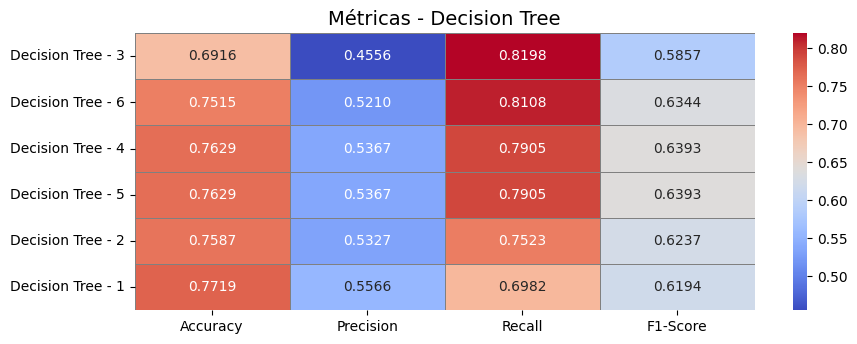

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
3,Decision Tree - 3,0.6916,0.4556,0.8198,0.5857,[ 0.6802 - 0.8048 ],"NearMiss, GridSearchCV"
6,Decision Tree - 6,0.7515,0.5210,0.8108,0.6344,[ 0.6832 - 0.8525 ],"RandomUnderSampler, GridSearchCV, selected_fea..."
4,Decision Tree - 4,0.7629,0.5367,0.7905,0.6393,[ 0.6755 - 0.8479 ],RandomUnderSampler
5,Decision Tree - 5,0.7629,0.5367,0.7905,0.6393,[ 0.6752 - 0.846 ],"RandomUnderSampler, GridSearchCV"
2,Decision Tree - 2,0.7587,0.5327,0.7523,0.6237,[ 0.8018 - 0.8737 ],"NearMiss, selected_features"
1,Decision Tree - 1,0.7719,0.5566,0.6982,0.6194,[ 0.6274 - 0.7935 ],NearMiss


In [ ]:
df_resultados = pd.DataFrame(metricas_tracking)
mostrar_modelos(df_resultados, "Decision Tree")


--- Resultados para Decision Tree - 1 
(NearMiss) ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1226
           1       0.56      0.70      0.62       444

    accuracy                           0.77      1670
   macro avg       0.72      0.75      0.73      1670
weighted avg       0.79      0.77      0.78      1670


--- Resultados para Decision Tree - 2 
(NearMiss, selected_features) ---
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1226
           1       0.53      0.75      0.62       444

    accuracy                           0.76      1670
   macro avg       0.71      0.76      0.72      1670
weighted avg       0.80      0.76      0.77      1670


--- Resultados para Decision Tree - 3 
(NearMiss, GridSearchCV) ---
              precision    recall  f1-score   support

           0       0.91      0.65      0.75      1226
           1       0.46      0.82      

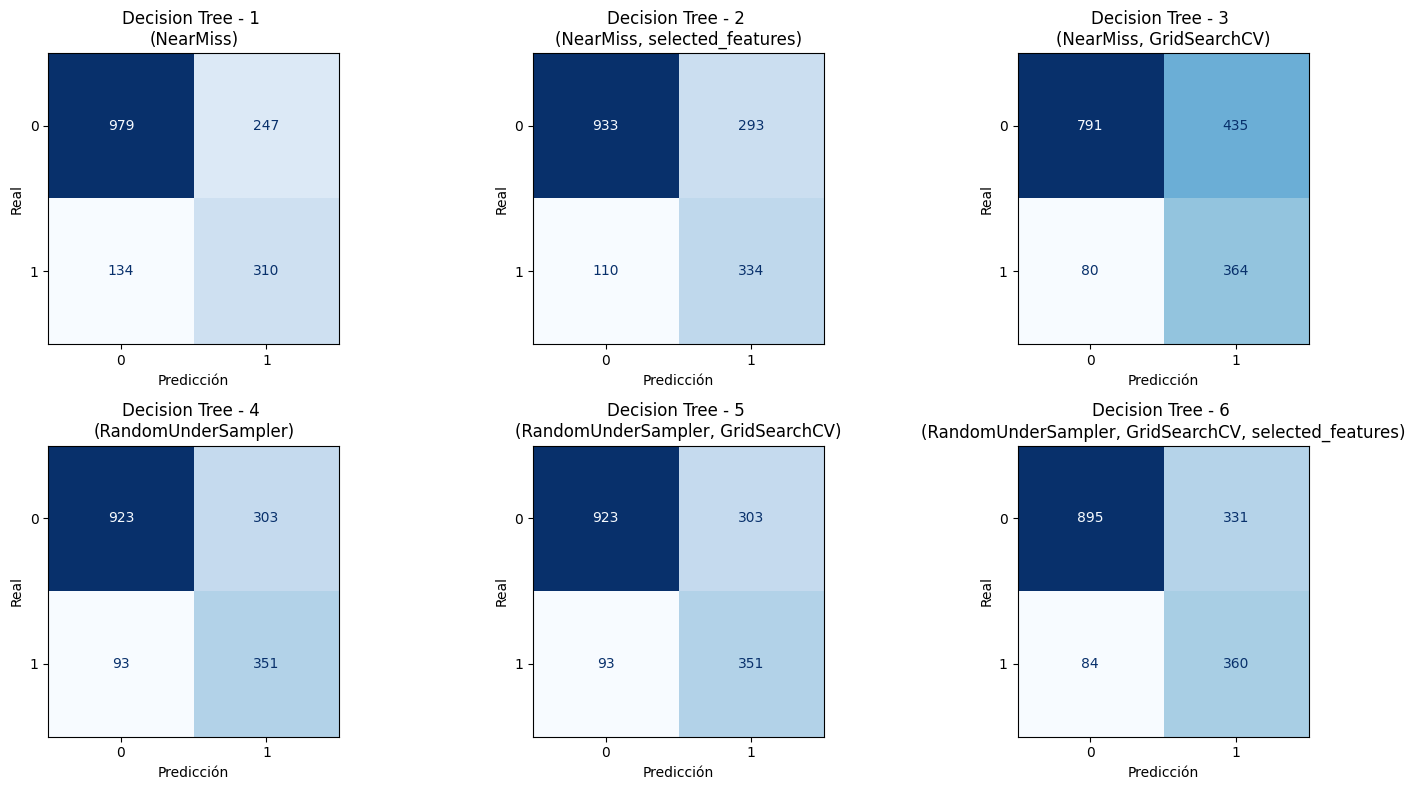

In [ ]:
modelos_info_dt = []
lista_y_preds_dt = [y_val_pred_dt1, y_val_pred_dt2, y_val_pred_dt3, y_pred_rus_dt4, y_pred_rus_dt5, y_pred_rus_dt6]

for i in range(1,7):
  dato = f'Decision Tree - {i} \n({df_resultados.Metodo[i]})'
  tupla = (dato, lista_y_preds_dt[i-1])
  modelos_info_dt.append(tupla)

evaluar_varios_modelos(modelos_info_dt, y_val)

### <font color='#f07c3e'>**Random Forest:**

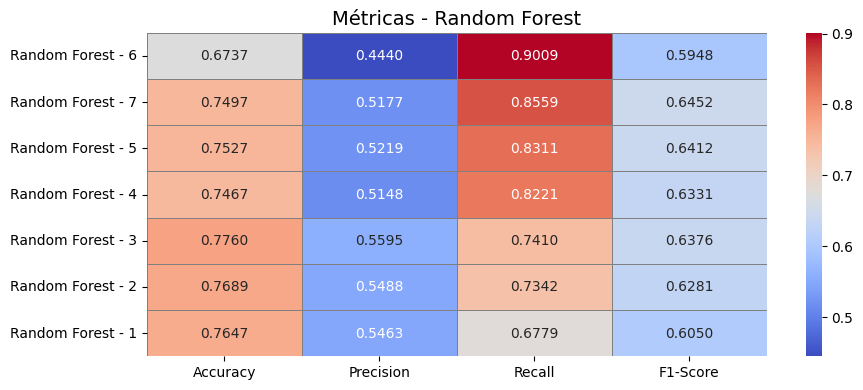

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
12,Random Forest - 6,0.6737,0.4440,0.9009,0.5948,[ 0.8305 - 0.9172 ],"RandomUnderSampler, selected_features, GridSea..."
13,Random Forest - 7,0.7497,0.5177,0.8559,0.6452,[ 0.7675 - 0.855 ],"RandomUnderSampler, selected_features, GridSea..."
11,Random Forest - 5,0.7527,0.5219,0.8311,0.6412,[ 0.7517 - 0.8495 ],"RandomUnderSampler, selected_features"
10,Random Forest - 4,0.7467,0.5148,0.8221,0.6331,[ 0.7632 - 0.8391 ],RandomUnderSampler
9,Random Forest - 3,0.7760,0.5595,0.7410,0.6376,[ 0.6536 - 0.7909 ],"NearMiss, GridSearchCV, selected_features"
8,Random Forest - 2,0.7689,0.5488,0.7342,0.6281,[ 0.6759 - 0.7946 ],"NearMiss, GridSearchCV"
7,Random Forest - 1,0.7647,0.5463,0.6779,0.6050,[ 0.5591 - 0.7593 ],NearMiss


In [ ]:
mostrar_modelos(df_resultados, "Random Forest")


--- Resultados para Random Forest - 1 
(NearMiss) ---
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1226
           1       0.55      0.68      0.61       444

    accuracy                           0.76      1670
   macro avg       0.71      0.74      0.72      1670
weighted avg       0.79      0.76      0.77      1670


--- Resultados para Random Forest - 2 
(NearMiss, GridSearchCV) ---
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1226
           1       0.55      0.73      0.63       444

    accuracy                           0.77      1670
   macro avg       0.72      0.76      0.73      1670
weighted avg       0.80      0.77      0.78      1670


--- Resultados para Random Forest - 3 
(NearMiss, GridSearchCV, selected_features) ---
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1226
           1       0.56  

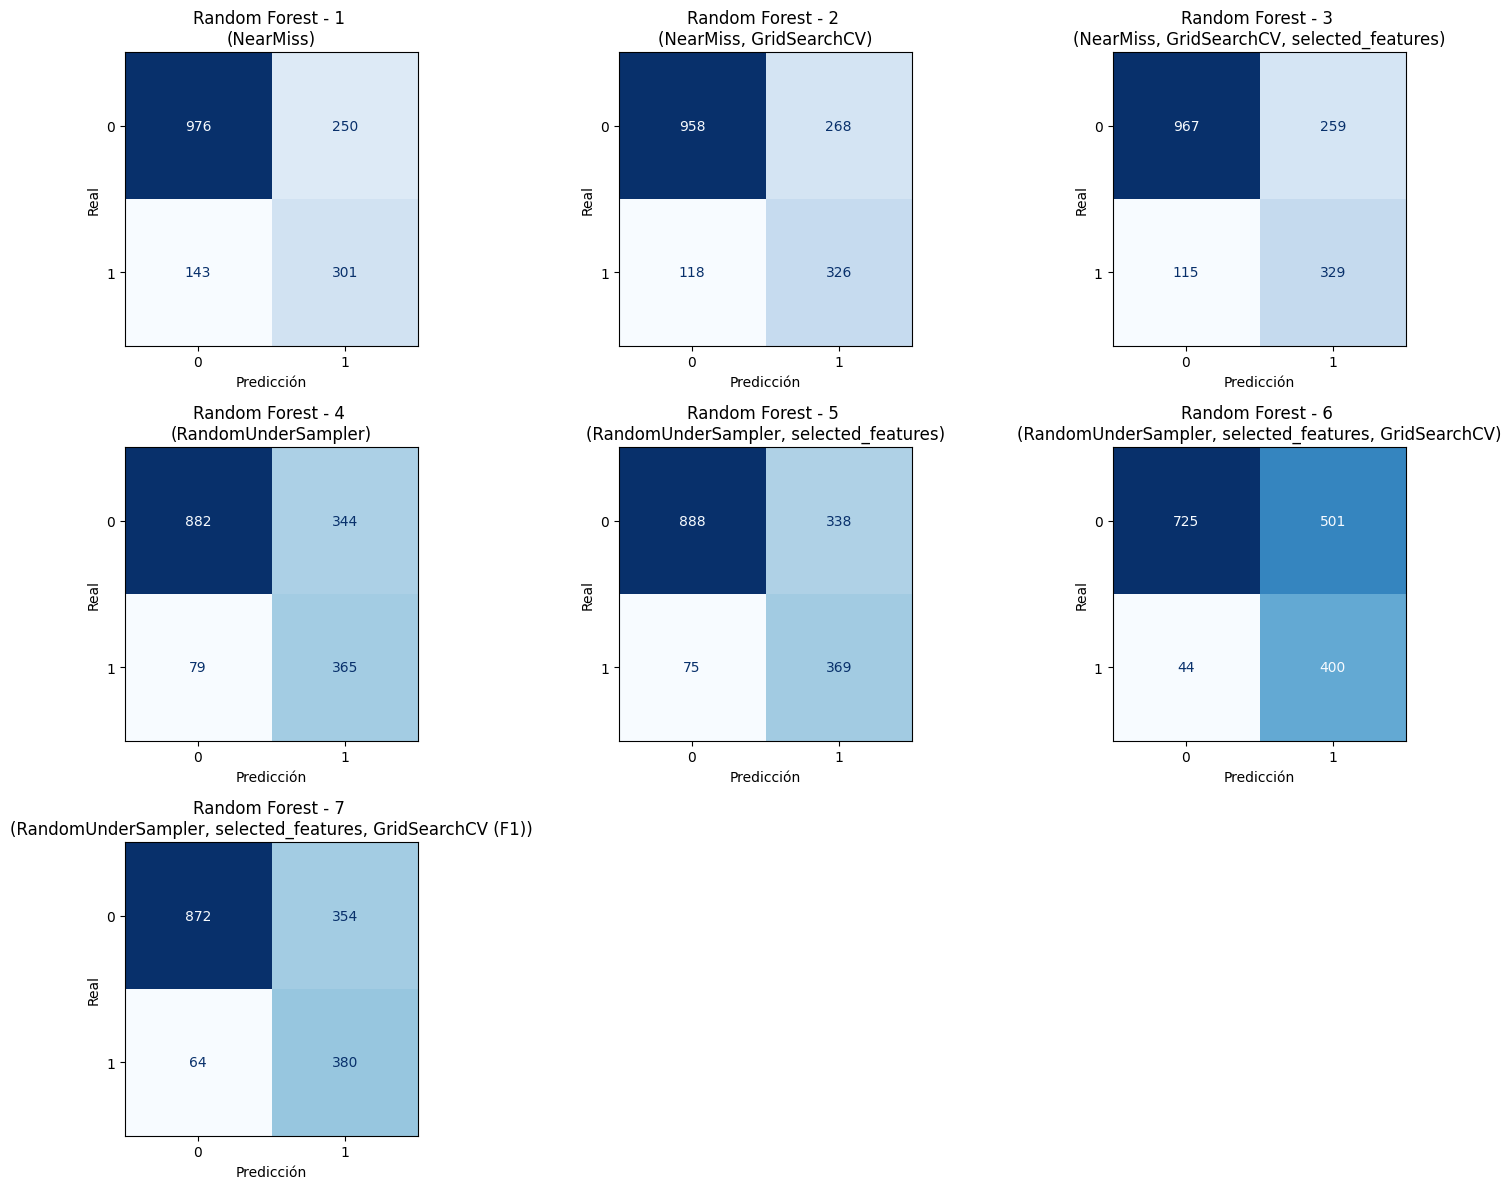

In [ ]:
modelos_info_rf = []
lista_y_preds_rf = [y_val_pred_rf1, y_val_pred_rf2, y_val_pred_rf3, y_val_pred_rf4, y_val_pred_rf5, y_val_pred_rf6, y_val_pred_rf7]

for i in range(7,14):
  dato = f'Random Forest - {i-6} \n({df_resultados.Metodo[i]})'
  tupla = (dato, lista_y_preds_rf[i-7])
  modelos_info_rf.append(tupla)

evaluar_varios_modelos(modelos_info_rf, y_val)

### <font color='#f07c3e'>**KNN  (K-Nearest Neighbors):**

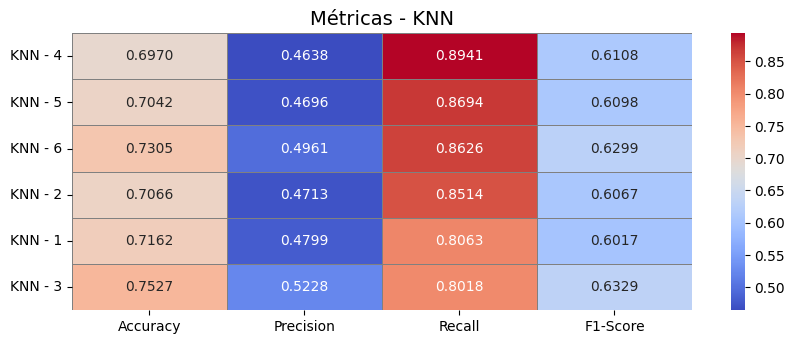

,Modelo,Accuracy,Precision,Recall,F1-Score,Intervalo de Confianza,Metodo
17,KNN - 4,0.6970,0.4638,0.8941,0.6108,[ 0.8082 - 0.8842 ],RandomUnderSampler
18,KNN - 5,0.7042,0.4696,0.8694,0.6098,[ 0.8007 - 0.8839 ],"RandomUnderSampler, GridSearchCV"
19,KNN - 6,0.7305,0.4961,0.8626,0.6299,[ 0.7927 - 0.8625 ],"RandomUnderSampler, GridSearchCV, permutation_..."
15,KNN - 2,0.7066,0.4713,0.8514,0.6067,[ 0.7842 - 0.8823 ],"NearMiss, GridSearchCV"
14,KNN - 1,0.7162,0.4799,0.8063,0.6017,[ 0.7174 - 0.8422 ],NearMiss
16,KNN - 3,0.7527,0.5228,0.8018,0.6329,[ 0.6357 - 0.7344 ],"NearMiss, GridSearchCV, permutation_importance"


In [ ]:
mostrar_modelos(df_resultados, "KNN")


--- Resultados para KNN - 1 
(NearMiss) ---
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1226
           1       0.48      0.81      0.60       444

    accuracy                           0.72      1670
   macro avg       0.69      0.74      0.69      1670
weighted avg       0.79      0.72      0.73      1670


--- Resultados para KNN - 2 
(NearMiss, GridSearchCV) ---
              precision    recall  f1-score   support

           0       0.92      0.65      0.77      1226
           1       0.47      0.85      0.61       444

    accuracy                           0.71      1670
   macro avg       0.70      0.75      0.69      1670
weighted avg       0.80      0.71      0.72      1670


--- Resultados para KNN - 3 
(NearMiss, GridSearchCV, permutation_importance) ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1226
           1       0.52      0.80      0.63       

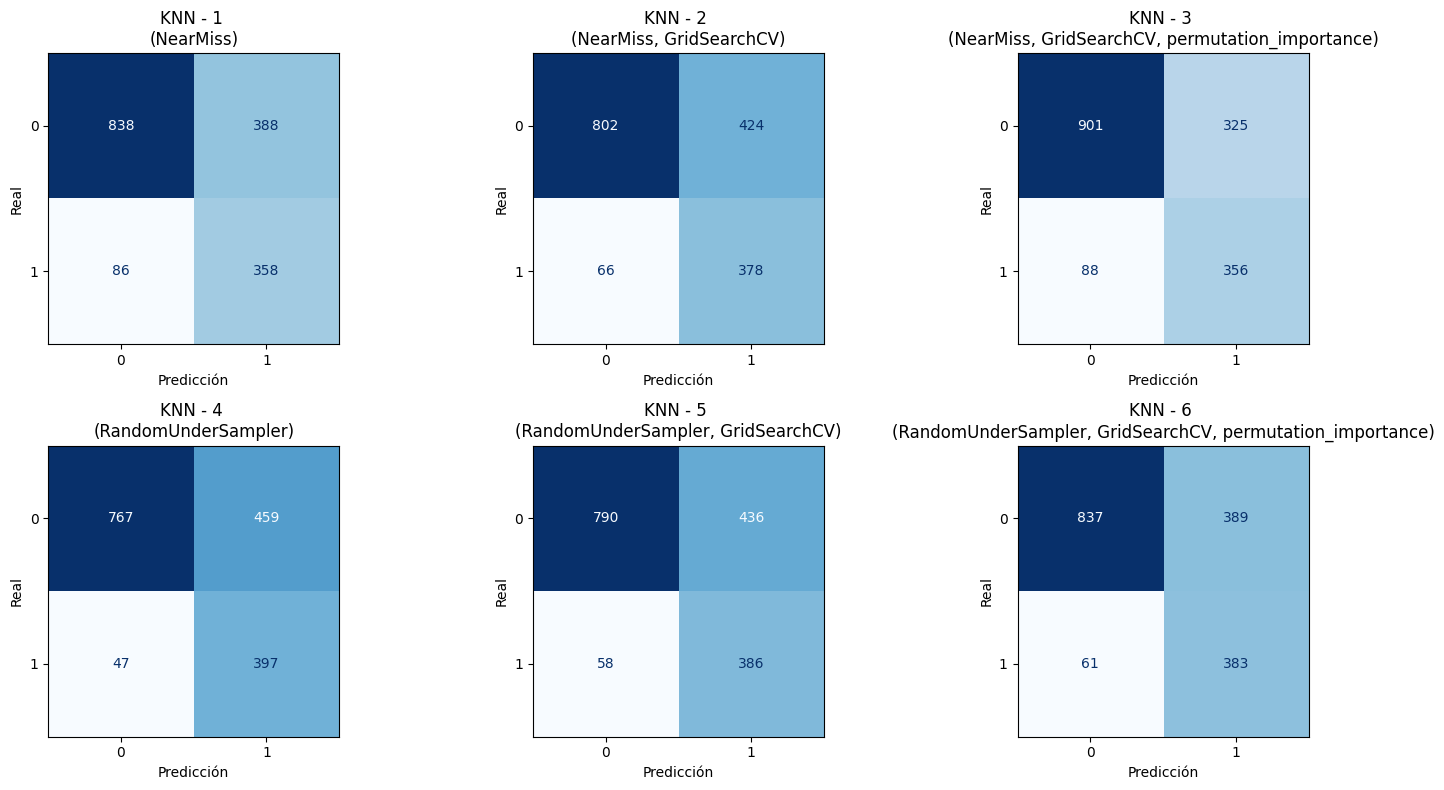

In [ ]:
modelos_info_knn = []
lista_y_preds_knn = [y_val_pred_knn1, y_val_pred_knn2, y_val_pred_knn3, y_val_pred_knn4, y_val_pred_knn5, y_val_pred_knn6]

for i in range(14,20):
  dato = f'KNN - {i-13} \n({df_resultados.Metodo[i]})'
  tupla = (dato, lista_y_preds_knn[i-14])
  modelos_info_knn.append(tupla)

evaluar_varios_modelos(modelos_info_knn, y_val)

Para poder decidir que modelo utilizar en la practica se resolveran dos preguntas.

* ¿Cuál modelo tuvo el mejor desempeño?
* ¿Algún modelo presentó overfitting o underfitting?

Para responder, primero debemos definir qué entendemos por "mejor".
En problemas de clasificación, esto depende del contexto:

* **Accuracy**: mide el porcentaje total de aciertos, pero puede ser engañoso si la clase está desbalanceada.

* **Precision**: mide qué proporción de las predicciones positivas son realmente positivas.

* **Recall** (Sensibilidad): mide qué proporción de los positivos reales se detectan.

* **F1-Score**: media armónica entre precisión y recall; útil cuando buscamos un balance entre ambas métricas.

En este caso, dado que trabajamos con un conjunto desbalanceado (se aplicaron NearMiss y RandomUnderSampler), el F1-Score es más representativo para evaluar el desempeño global. El recall es especialmente relevante si el objetivo es detectar la mayor cantidad de casos positivos posibles (por ejemplo, en problemas médicos o de fraude).



### <font color='#f07c3e'>**Decision Tree:**

#### <font color='#58D68D'>**¿Cuál modelo tuvo el mejor desempeño?**</font>


**1. Métricas críticas para churn**

* **Recall de clase 1** (`Recall`): Es crucial, porque indica cuántos clientes que realmente abandonarán detectamos. Un recall bajo significa perder clientes que podríamos retener.

* **Precision de clase 1** (`Precision`): También importante, porque indica cuántos de los clientes que predijimos que se irían realmente se irán. Precision baja significa que podríamos gastar recursos en clientes que no abandonarían.

* **F1-score de clase 1**: Combina `recall` y `precision`, útil para balancear el riesgo de perder clientes vs. gastar recursos innecesarios.

| Modelo                                                      | Precision clase 1 | Recall clase 1 | F1 clase 1 | Comentario sobre churn                                                                                           |
| ----------------------------------------------------------- | ----------------- | -------------- | ---------- | ---------------------------------------------------------------------------------------------------------------- |
| DT-1 (NearMiss)                                             | 0.56              | 0.70           | 0.62       | Detecta 70% de los churners, precision moderada → buen balance para retención.                                   |
| DT-2 (NearMiss, selected\_features)                         | 0.53              | 0.75           | 0.62       | Detecta más churners (recall 0.75) pero precision baja → se podrían gastar recursos en clientes que no se irían. |
| DT-3 (NearMiss, GridSearchCV)                               | 0.46              | 0.82           | 0.59       | Recall alto (82%) pero precision muy baja → identifica muchos churners pero genera demasiadas falsas alarmas.    |
| DT-4 (RandomUnderSampler)                                   | 0.54              | 0.79           | 0.64       | Buen recall (79%) y precision aceptable → balance decente para campañas de retención.                            |
| DT-5 (RandomUnderSampler, GridSearchCV)                     | 0.54              | 0.79           | 0.64       | Igual que DT-4                                                                                                   |
| DT-6 (RandomUnderSampler, GridSearchCV, selected\_features) | 0.52              | 0.81           | 0.63       | Recall alto (81%) pero precision ligeramente menor → riesgo moderado de falsas alarmas.                          |


Al evaluar los modelos de Decision Tree para predecir clientes que podrían abandonar (`churn`), es importante considerar dos enfoques estratégicos:

a) **Priorizar la detección de `churn`**

* **Modelos destacados:** DT-3 y DT-6.

* **Característica principal:** tienen el recall más alto en la clase de clientes que abandonarán.

* **Interpretación:** estos modelos logran identificar a la mayoría de los clientes que efectivamente se irán.

* **Limitación:** la precision es baja, lo que significa que también clasifican incorrectamente como abandono a clientes que en realidad permanecerán.

* **Impacto práctico:** son útiles cuando el objetivo principal es minimizar la pérdida de clientes, aunque implique gastar recursos en algunos clientes que no abandonarían.

b) **Balance entre detección de `churn` y eficiencia**

* **Modelos destacados:** DT-1, DT-4 y DT-5.

* **Característica principal:** combinan un recall decente con una precision aceptable.

* **Interpretación:** detectan una buena proporción de abandono, pero al mismo tiempo reducen los falsos positivos.

* **Impacto práctico:** ideales para campañas de retención, donde se busca eficiencia en el uso de recursos y se desea enfocarse en clientes con mayor probabilidad real de abandonar.

**Conclusión:**

La prioridad es optimizar recursos en campañas de retención, el  más recomendable es DT-6 ya que el intervalo de confianza es alto, aunque el la precision es de `52 %` solo tien una diferencia de `1 %` comparado con los modelos DT-5 y DT-4.

![texto del vínculo](https://raw.githubusercontent.com/EJoelCM/analisis_predictivo_telecomX/refs/heads/main/imagenes/DecisionTree6_ConfusionMatrix.png)

#### <font color='#58D68D'>**¿Algún modelo presentó overfitting o underfitting?**</font>

**Posibles casos de Overfitting**

**Decision Tree - 3:**

* **Clase 1:** `Recall` alto (`0.82`) pero `Precision` muy bajo (`0.46`) → detecta casi todos los positivos, pero clasifica muchos negativos erróneamente.

* Indica que el modelo pudo haberse ajustado demasiado a los datos de entrenamiento, aprendiendo a “marcar positivos” con excesiva agresividad.



**Posibles casos de Underfitting**

Ninguno muestra underfitting grave, pero:

* `Decision Tree - 1` tiene el recall de clase 1 un poco más bajo (0.70) → puede  estar perdiendo algunos positivos, pero es un trade-off aceptable con alta precision (0.56).

* `Decision Tree - 2` similar, recall clase 1 = 0.75, precision = 0.53.

Posibles ajustes si se desea mejorar recall:

* Permitir mayor profundidad o ramas adicionales.

* Ajustar features usadas (`selected_features`), agregar más información relevante.

### <font color='#f07c3e'>**Random Forest:**

#### <font color='#58D68D'>**¿Cuál modelo tuvo el mejor desempeño?**</font>


| Modelo                                                         | Precision clase 1 | Recall clase 1 | F1 clase 1 | Comentario sobre churn                                                                                         |
| -------------------------------------------------------------- | ----------------- | -------------- | ---------- | -------------------------------------------------------------------------------------------------------------- |
| RF-1 (NearMiss)                                                | 0.55              | 0.68           | 0.61       | Detecta 68% de churners, precision moderada → balance decente para retención.                                  |
| RF-2 (NearMiss, GridSearchCV)                                  | 0.55              | 0.73           | 0.63       | Recall mejora a 73%, precision igual → identifica más churners pero con más falsos positivos.                  |
| RF-3 (NearMiss, GridSearchCV, selected\_features)              | 0.56              | 0.74           | 0.64       | Mejor balance entre detectar churners y eficiencia → recomendable.                                             |
| RF-4 (RandomUnderSampler)                                      | 0.51              | 0.82           | 0.63       | Recall alto (82%), detecta más churners, pero precision baja → riesgo de falsas alarmas.                       |
| RF-5 (RandomUnderSampler, selected\_features)                  | 0.52              | 0.83           | 0.64       | Similar a RF-4, recall ligeramente superior → detecta más churners.                                            |
| RF-6 (RandomUnderSampler, selected\_features, GridSearchCV)    | 0.44              | 0.90           | 0.59       | Recall máximo (90%), pero precision muy baja → muchas falsas alarmas, puede sobrecargar campañas de retención. |
| RF-7 (RandomUnderSampler, selected\_features, GridSearchCV F1) | 0.52              | 0.86           | 0.65       | Buen recall (86%) y precision moderada → más equilibrado que RF-6 para campañas de retención.                  |


a) **Priorizar detección de churn**

* Modelos destacados: `RF-6` y `RF-7`

* **Característica:** tienen recall más alto para clientes que abandonarán.

* **Impacto práctico:** permiten minimizar la pérdida de clientes, aunque generan más falsas alarmas y posible gasto en clientes que no se irán.

b) **Balance entre detección y eficiencia**

* **Modelos destacados:** `RF-2`, `RF-3`, `RF-5`

* **Característica:** combinan recall decente con precision aceptable.

* **Impacto práctico:** identifican una buena proporción de abandono sin generar tantas falsas alarmas → óptimos para campañas de retención eficientes.

**Conclusión**

Modelo más equilibrado: `RF-3`, `RF-5` y `RF-7`

* Buen balance entre detectar churners y eficiencia en recursos.

Modelo para máxima detección de churners: `RF-6`

* Ideal si se busca minimizar cualquier pérdida de clientes, pero con mayor riesgo de gastar recursos en clientes que no abandonarían.

El modelo con mejor desempeño es `RF-5` ya que es el que presenta el mejor `F1-score` (`0.64`) considerando ahorrar recursos y evitar molestias en clientes que no cancelaran el servicio

![Matriz de Confusion - Modelo Random Forest 5](https://raw.githubusercontent.com/EJoelCM/analisis_predictivo_telecomX/refs/heads/main/imagenes/RandomForest5_ConfusionMatrix.png)



#### <font color='#58D68D'>**¿Algún modelo presentó overfitting o underfitting?**</font>

**Overfitting:**

* `RF-6`: `recall` muy alto (`0.90`) pero `precision` baja (`0.44`) → riesgo de sobreajuste a los datos de entrenamiento, generando muchas falsas alarmas.

**Underfitting:**

* Ninguno grave, pero `RF-1` tiene `recall` más bajo (`0.68`) → puede perder algunos churners, aunque mantiene precision aceptable.

### <font color='#f07c3e'>**KNN  (K-Nearest Neighbors):**

#### <font color='#58D68D'>**¿Cuál modelo tuvo el mejor desempeño?**</font>


| Modelo                                                            | Precision clase 1 | Recall clase 1 | F1 clase 1 | Comentario sobre churn                                                                                      |
| ----------------------------------------------------------------- | ----------------- | -------------- | ---------- | ----------------------------------------------------------------------------------------------------------- |
| KNN-1 (NearMiss)                                                  | 0.48              | 0.81           | 0.60       | Detecta 81% de churners, precision baja → algunas falsas alarmas pero buen recall.                          |
| KNN-2 (NearMiss, GridSearchCV)                                    | 0.47              | 0.85           | 0.61       | Recall mejora a 85%, precision baja → riesgo de gastar recursos en clientes que no se irían.                |
| KNN-3 (NearMiss, GridSearchCV, permutation\_importance)           | 0.52              | 0.80           | 0.63       | Mejor balance entre precision y recall → buena opción para retención.                                       |
| KNN-4 (RandomUnderSampler)                                        | 0.46              | 0.89           | 0.61       | Recall muy alto (89%), precision baja → detecta casi todos los churners, pero genera muchas falsas alarmas. |
| KNN-5 (RandomUnderSampler, GridSearchCV)                          | 0.47              | 0.87           | 0.61       | Similar a KNN-4, recall ligeramente menor → todavía alto riesgo de falsas alarmas.                          |
| KNN-6 (RandomUnderSampler, GridSearchCV, permutation\_importance) | 0.50              | 0.86           | 0.63       | Buen recall (86%) y precision moderada → más equilibrado que KNN-4/5 para campañas de retención.            |


a) **Priorizar la detección de churners**

* **Modelos destacados**: `KNN-4` y `KNN-5`

* **Característica:** tienen `recall` más alto para clientes que abandonarán (`0.89` y `0.87`).

* **Impacto práctico:** identifican casi todos los churners, pero a costa de muchas falsas alarmas → mayor gasto en clientes que no se irían.

b) **Balance entre detección y eficiencia**

* **Modelos destacados:** `KNN-3` y `KNN-6`

* **Característica:** combinan `recall` alto con `precision` ligeramente superior.

* **Impacto práctico:** detectan la mayoría de los churners, pero reducen falsos positivos → óptimos para campañas de retención eficientes.

**Conclusión**

Modelo más equilibrado: `KNN-3` y `KNN-6`

* Buen balance entre detectar churners y eficiencia en recursos de retención.

Modelo para máxima detección de churners: `KNN-4`

* Detecta casi todos los clientes que se irían, pero con muchas falsas alarmas.

El modelo que tiene mejor desempeño es `KNN-6` ya que aunque `KNN-3` tiene un mayor `F1-score` y `precision` al momento de realizar el modelo se tienen varios warnings por la poca cantidad de datos, lo que hace que el intervalo de confianza no sea el correcto

![Matriz de Confusion - KNN 6](https://raw.githubusercontent.com/EJoelCM/analisis_predictivo_telecomX/refs/heads/main/imagenes/KNN6_ConfusionMatrix.png)



#### <font color='#58D68D'>**¿Algún modelo presentó overfitting o underfitting?**</font>

**Overfitting:**

* `KNN-4` y `KNN-5`: `recall` muy alto pero precision baja → riesgo de sobreajuste y falsas alarmas en predicción.

**Underfitting:**

Ninguno grave. `KNN-1` y `KNN-2` tienen `recall` más bajo (`81–85%`) pero `precision` baja → podrían perder algunos churners, aunque balancea menos falsas alarmas que los modelos más agresivos.

### <font color='#58D68D'>**Conclusion - Comparativa de los 3 modelos**</font>


| Modelo            | Precision clase 1 | Recall clase 1 | F1 clase 1 | Comentario sobre churn                                                                                                                  |
| ----------------- | ----------------- | -------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| Decision Tree - 6 | 0.52              | 0.81           | 0.63       | Buen recall (81%), precision moderada → detecta la mayoría de churners, con falsos positivos moderados.                                 |
| Random Forest - 5 | 0.52              | 0.83           | 0.64       | Recall ligeramente superior (83%), precision igual → detecta más churners que DT-6, balance razonable entre detección y falsas alarmas. |
| KNN - 6           | 0.50              | 0.86           | 0.63       | Recall más alto (86%), precision algo menor → identifica casi todos los churners, pero genera más falsas alarmas.                       |


a) **Priorizar detección de churners**

* **Modelo recomendado:** `KNN-6`

* **Razonamiento:** tiene el `recall` más alto (`0.86`), por lo que detecta casi todos los clientes que podrían abandonar.

* **Limitación:** `precision` baja (`0.50`), lo que significa que algunas predicciones incorrectas pueden llevar a gastar recursos en clientes que no se irían.

b) **Balance entre detección y eficiencia**

* **Modelo recomendado:** `Random Forest-5`

* **Razonamiento:** combina `recall` alto (`0.83`) y `precision` moderada (`0.52`), logrando un buen balance para campañas de retención eficientes.

* **Alternativa:** `Decision Tree-6`

* `Recall` ligeramente menor (`0.81`), `precision` igual (`0.52`) → menos falsos positivos, un poco más conservador en gasto de recursos.

**Conclusión comparativa**

Para máxima detección de churners: `KNN-6`

* Detecta casi todos los clientes que se irían, aunque genera más falsas alarmas.

Para balance detección/eficiencia: `Random Forest-5`

* Buen `recall` y `precision` moderada → ideal para campañas de retención con recursos limitados.
* Su intervalo de confianza (`0.7517 - 0.8495`) es optimo para el objetivo de predecir clientes que abandonaran el servicio



***
# <font color=lightblue size=6>6. Interpretación y Conclusiones</font>
***

## <font color='#EB984E'>**Análisis de la Importancia de las Variables**</font>

### <font color='#f07c3e'>**Decision Tree - 6:**

El model `Decision Tree` con mejor desempeño es el `Decision Tree - 6`, durante el proceso de dicho modelo se realiza undersamplig con `RandomUnderSampler`, ajuste de hiperparametros con `GridSearchCV` se seleccionan las variables con mejor desempeño para el modelo de las cuales se eligen las siguientes variables con su respectiva importancia:
* `Contract_Month-to-month` - 58.02 %
* `InternetService_Fiber optic` - 13.37 %
* `tenure` - 10.68%
* `ChargesTotal` - 3.74 %
* `Contract_One year` - 3.06 %


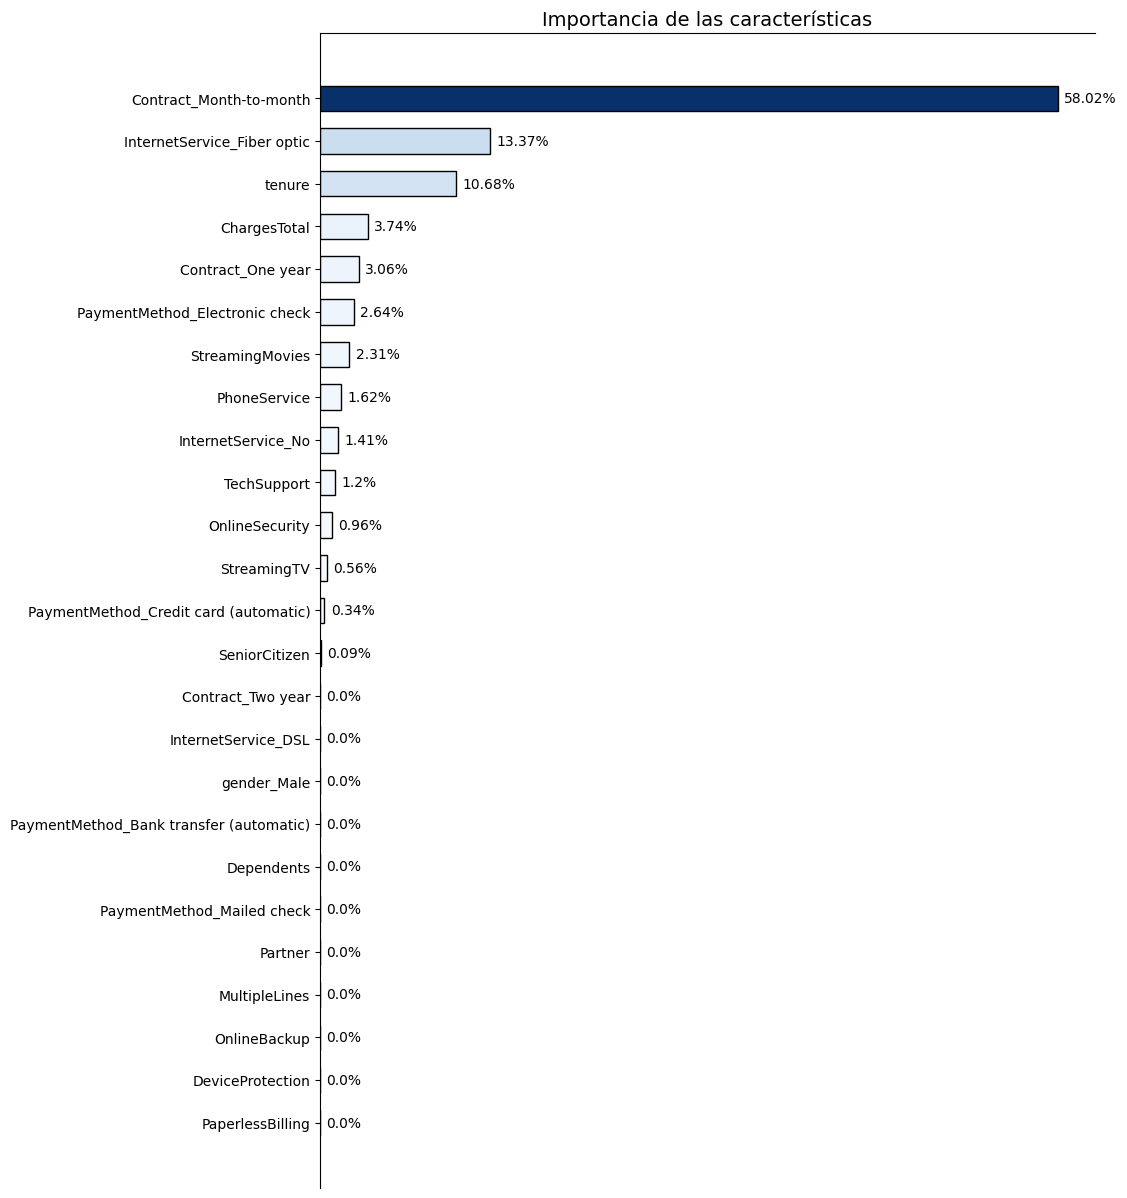

In [ ]:
plot_feature_importances(modelo_descisionTree5,X)

### <font color='#f07c3e'>**Random Forest - 5:**

El modelo `Random Forest` con mejor desempeño es el `Random Forest - 5`, durante el proceso de dicho modelo se realiza undersamplig con `RandomUnderSampler` y se seleccionan las variables con mejor desempeño para el modelo de las cuales se eligen las siguientes variables con su respectiva importancia:

* `tenure` - 16.42 %
* `ChargesTotal` - 15.35 %
* `Contract_Month-to-month` 11.81 %
* `Contract_Two year`	7.15 %
* `InternetService_Fiber optic` 6.9 %
* `PaymentMethod_Electronic check` - 4.71%
* `InternetService_No` - 3.93 %
* `PaperlessBilling` - 2.84 %
* `OnlineSecurity` - 2.42 %
* `Dependents` - 2.32 %
* `TechSupport`	- 2.25 %
* `StreamingMovies`	- 2.14 %
* `SeniorCitizen`	- 2.12 %
* `Contract_One year`	- 2.08 %
* `gender_Male` - 2.04 %
* `StreamingTV`	- 1.99 %
* `OnlineBackup` - 1.99 %
* `MultipleLines` - 1.93 %
* `Partner` - 1.92 %
* `InternetService_DSL` - 1.61 %

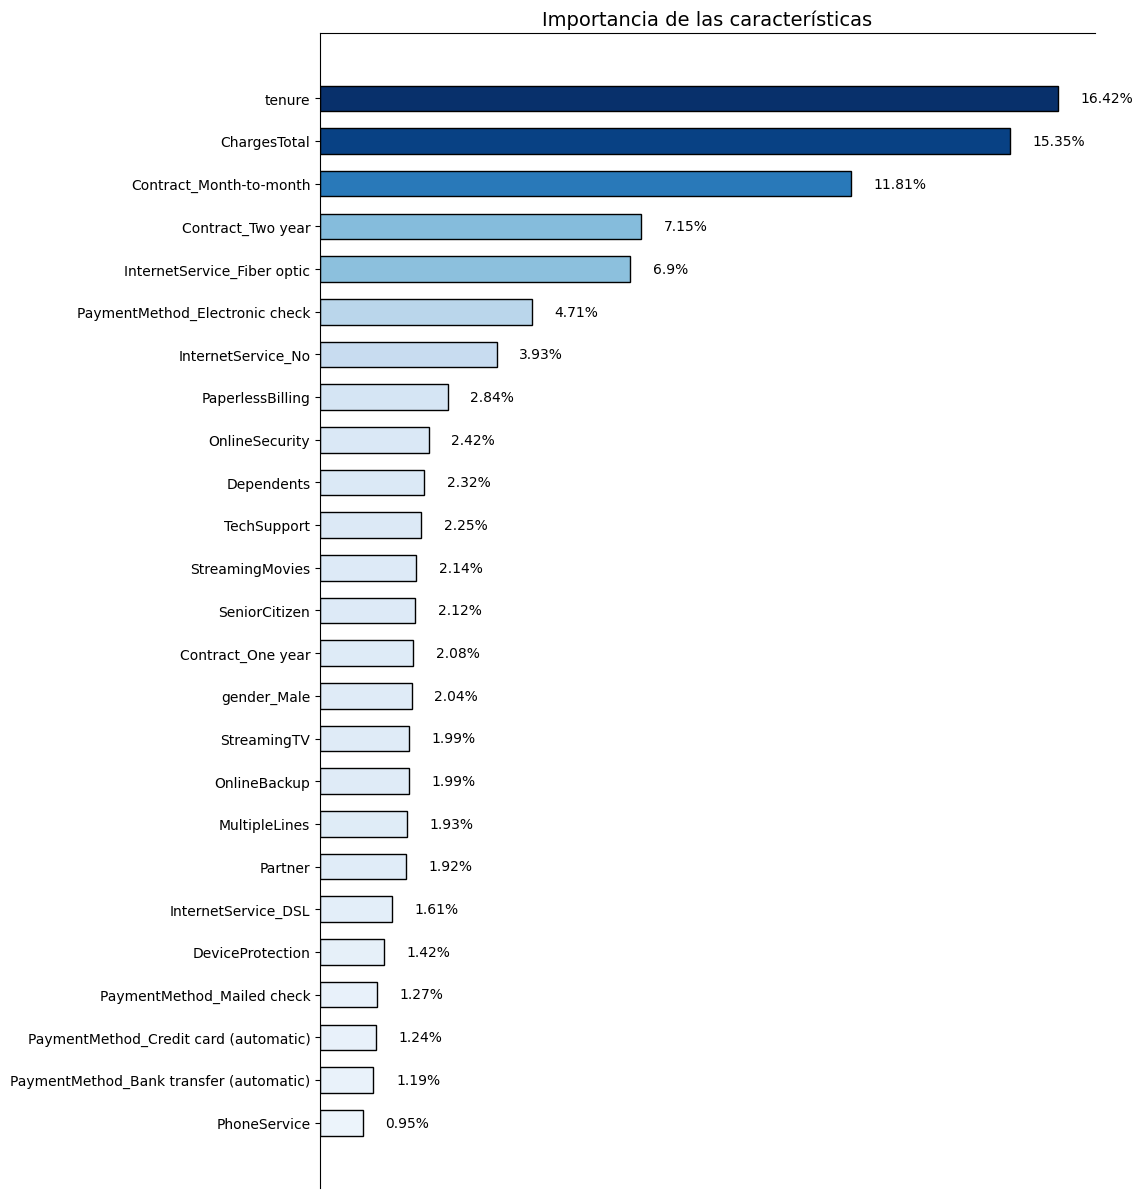

In [ ]:
plot_feature_importances(modelo_rf4,X)

### <font color='#f07c3e'>**KNN  (K-Nearest Neighbors) - 6:**

Para evaluar la relevancia de cada característica en el modelo `KNN` (K-Nearest Neighbors), se utilizará el método `Permutation Importance`.
Este enfoque no depende de los coeficientes internos del modelo, ya que `KNN` es un algoritmo basado en distancias y no en pesos, sino que mide cómo afecta al rendimiento del modelo el hecho de alterar aleatoriamente los valores de una característica específica.

El modelo `KNN` con mejor desempeño es el `KNN - 6`, durante el proceso de dicho modelo se realiza undersamplig con `RandomUnderSampler`, ajuste de hiperparametros con `GridSearchCV` y se seleccionan las variables con mejor desempeño con `permutation_importance` para el modelo de las cuales se eligen las siguientes variables con su respectiva importancia:

* `tenure` - 1.53 %
* `Contract_Month-to-month` - 1.06 %
* `OnlineBackup` - 1.01 %
* `InternetService_Fiber optic` - 0.55 %
* `ChargesTotal` - 0.48 %
* `Dependents` - 0.48 %
* `InternetService_No` - 0.46 %
* `TechSupport` - 0.45 %
* `PaymentMethod_Credit card (automatic)` - 0.34 %
* `Contract_One year` - 0.32 %
* `Contract_Two year` - 0.26 %
* `PaperlessBilling` - 0.17 %
* `InternetService_DSL` - 0.16 %
* `DeviceProtection` - 0.12 %
* `PaymentMethod_Electronic check` - 0.07 %
* `OnlineSecurity` - 0.05 %
* `Partner` - 0.03 %
* `gender_Male` - -0.13 %


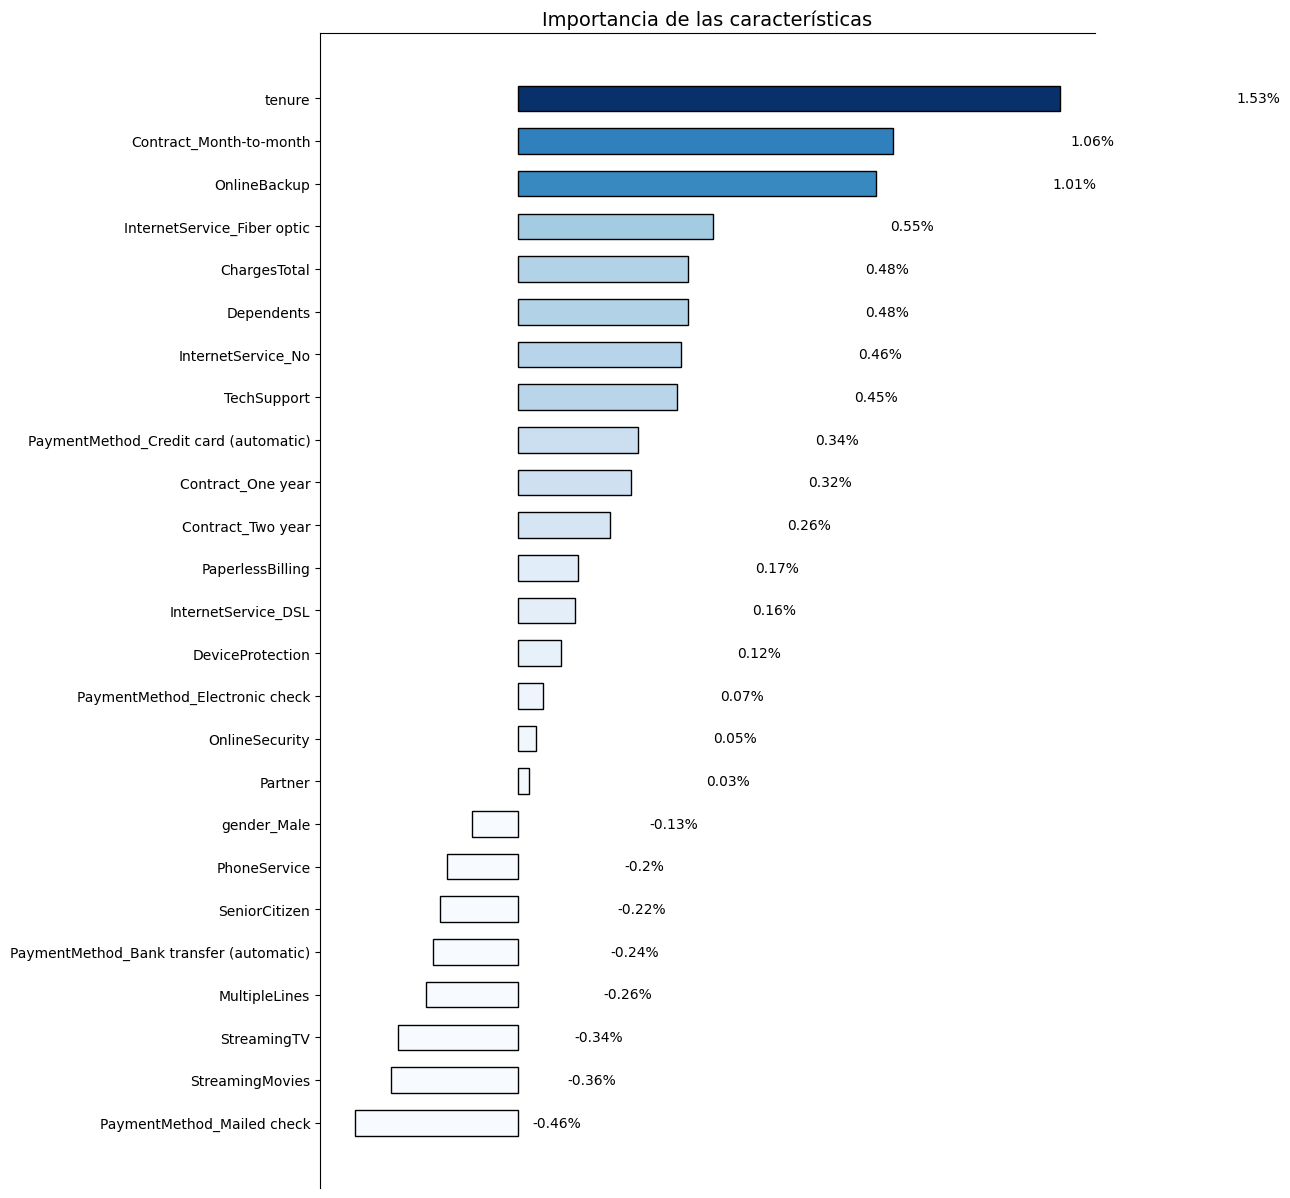

In [ ]:
plot_feature_importances_knn(feature_importances)


## <font color='#EB984E'>**Conclusion**</font>

### <font color='#f07c3e'>**1. Factores que más influyen en la cancelación**


El análisis combinado de `Decision Tree`, `Random Forest` y `KNN` muestra que existen patrones consistentes en las variables más determinantes para predecir el abandono (`churn`).
Entre ellas destacan:

* `tenure` — Los clientes con menor antigüedad tienen una probabilidad significativamente más alta de cancelar.

* `Contract_Month-to-month` — Contratos mensuales se asocian con mayor riesgo de abandono en comparación con contratos de un año o dos años.

* `ChargesTotal` — Altos cargos acumulados se relacionan con mayor insatisfacción y churn.

* `InternetService_Fiber optic` — Este tipo de servicio presenta una tasa de cancelación más alta que otros.

* **Servicios adicionales**  (`OnlineBackup`, `TechSupport`, `OnlineSecurity`) — La ausencia de estos servicios está correlacionada con una mayor probabilidad de cancelación.

* **Métodos de pago** — En particular, `PaymentMethod_Electronic check` aparece como un indicador de mayor abandono.

* **Características demográficas** como `SeniorCitizen` o `Dependents` muestran una influencia menor pero constante.


### <font color='#f07c3e'>**2. Desempeño de modelos predictivos**


**2.1 Máxima detección de abandono**

* **Modelo recomendado:** `KNN-6`

* **Métricas:** `Recall = 0.86`, `Precision = 0.50`.

* **Ventajas:** Detecta la mayoría de clientes que se irán.

* **Limitación:** Alta cantidad de falsos positivos, lo que incrementa el gasto en clientes que realmente no cancelarían.

**2.2 Balance entre detección y eficiencia**

* **Modelo recomendado:** `Random Forest-5`

* **Métricas:** `Recall = 0.83`, `Precision = 0.52`, `F1-score = 0.64`.

* **Ventajas:** Buen equilibrio entre alcance y uso eficiente de recursos.

* **Intervalo de confianza:** `0.7517 – 0.8495`.

* **Alternativa:** `Decision Tree-6` con `Recall = 0.81` y misma `Precision (0.52)`, ligeramente más conservador.

### <font color='#f07c3e'>**3. Variables más importantes por modelo**




**Random Forest-5**

* `tenure` - 16.42 %
* `ChargesTotal` - 15.35 %
* `Contract_Month-to-month` 11.81 %
* `Contract_Two year`	7.15 %
* `InternetService_Fiber optic` 6.9 %
* `PaymentMethod_Electronic check` - 4.71%
* `InternetService_No` - 3.93 %
* `PaperlessBilling` - 2.84 %
* `OnlineSecurity` - 2.42 %
* `Dependents` - 2.32 %
* `TechSupport`	- 2.25 %
* `StreamingMovies`	- 2.14 %
* `SeniorCitizen`	- 2.12 %
* `Contract_One year`	- 2.08 %
* `gender_Male` - 2.04 %
* `StreamingTV`	- 1.99 %
* `OnlineBackup` - 1.99 %
* `MultipleLines` - 1.93 %
* `Partner` - 1.92 %
* `InternetService_DSL` - 1.61 %

KNN-6

* `tenure` - 1.53 %
* `Contract_Month-to-month` - 1.06 %
* `OnlineBackup` - 1.01 %
* `InternetService_Fiber optic` - 0.55 %
* `ChargesTotal` - 0.48 %
* `Dependents` - 0.48 %
* `InternetService_No` - 0.46 %
* `TechSupport` - 0.45 %
* `PaymentMethod_Credit card (automatic)` - 0.34 %
* `Contract_One year` - 0.32 %
* `Contract_Two year` - 0.26 %
* `PaperlessBilling` - 0.17 %
* `InternetService_DSL` - 0.16 %
* `DeviceProtection` - 0.12 %
* `PaymentMethod_Electronic check` - 0.07 %
* `OnlineSecurity` - 0.05 %
* `Partner` - 0.03 %
* `gender_Male` - -0.13 %


**Decision Tree-6**

* `Contract_Month-to-month` - 58.02 %
* `InternetService_Fiber optic` - 13.37 %
* `tenure` - 10.68%
* `ChargesTotal` - 3.74 %
* `Contract_One year` - 3.06 %



### <font color='#f07c3e'>**4. Estrategias de retención**



Para clientes de alto riesgo (detección máxima – KNN-6)

* Ofertas proactivas a clientes nuevos y con contratos mensuales.

* Paquetes de servicios adicionales gratuitos o con descuento (OnlineBackup, TechSupport).

* Campañas de contacto temprano para clientes con altos cargos acumulados.

Para campañas eficientes (balance – Random Forest-5)

* Migración a contratos de mayor duración con incentivos.

* Bonificaciones por permanencia a clientes que superen ciertos meses de tenure.

* Optimización de soporte técnico y seguridad en línea para incrementar la percepción de valor.



### <font color='#f07c3e'>**5. Conclusión comparativa**




* **Máxima detección de churn** `KNN-6` → útil para minimizar la pérdida total, aceptando más falsos positivos.

* **Mejor balance detección/eficiencia**: `Random Forest-5` → ideal para campañas de retención optimizando recursos.

* Factores clave en todos los modelos: Antigüedad, tipo de contrato, tipo de servicio de internet, cargos acumulados y servicios adicionales.